# Data Strikes (and Boycotts): Simulated Campaign Results

## What's in this notebook?
This notebook includes code for exploring the results of simulated boycotts. It also generates plots (for papers/presentations). This notebook covers 3 broad categories of experiments

1. MovieLens 1M random boycotts
2. MovieLens 1M homogeneous boycotts (e.g. fans of Comedy movies boycott together, people of a single age group boycott together)
3. MovieLens 20M random boycotts

It uses code from p_b_curve.py for plotting
It preloads constants from viz_constants (# users, # ratings, # hits). Can see how those are computed in ratings_hists notebook.


In [10]:
import viz_constants 
import importlib

# reload constants from file
# see https://support.enthought.com/hc/en-us/articles/204469240-Jupyter-IPython-After-editing-a-module-changes-are-not-effective-without-kernel-restart
importlib.reload(viz_constants)
(
    num_users, num_ratings, num_hits
) = (
    viz_constants.num_users, viz_constants.num_ratings, viz_constants.num_hits
)
num_users, num_ratings, num_hits

({'ml-1m': 6040}, {'ml-1m': 1000209}, {'ml-1m': 575281})

In [11]:
from collections import defaultdict, OrderedDict
import json
from pprint import pprint

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set_color_codes("dark")

import scipy
from scipy import stats
from scipy.interpolate import interp1d

# http://files.grouplens.org/datasets/movielens/ml-20m-README.txt

for dataset in ['ml-1m']:
    ratio = num_ratings[dataset] / num_users[dataset]
    print(dataset, 'ratio of ratings to users:', ratio)

ml-1m ratio of ratings to users: 165.5975165562914


In [12]:
print('Pandas:', pd.__version__, 'Seaborn:', sns.__version__, 'numpy:', np.__version__, 'scipy:', scipy.__version__)

Pandas: 1.4.4 Seaborn: 0.11.2 numpy: 1.23.4 scipy: 1.8.1


First things first: let's load our master data files. Each is a single csv that was created by the `process_all.py` script.

In [13]:
df_1m = pd.read_csv('all_results.csv', dtype={'indices': str})
df_1m['dataset'] = 'ml-1m'
assert len(df_1m) == len(df_1m[df_1m.ratingfrac.notna()])

In [14]:
pd.set_option('display.max_columns', None)
df_1m[500:505]

,Unnamed: 0.1,name,algo_name,indices,ratingfrac,userfrac,Unnamed: 0,num_ratings,num_users,num_movies,rmse_all,standards_rmse_all,rmse_non-boycott,standards_rmse_non-boycott,rmse_boycott,standards_rmse_boycott,rmse_all-like-boycott,standards_rmse_all-like-boycott,mae_all,standards_mae_all,mae_non-boycott,standards_mae_non-boycott,mae_boycott,standards_mae_boycott,mae_all-like-boycott,standards_mae_all-like-boycott,prec10t4_all,standards_prec10t4_all,prec10t4_non-boycott,standards_prec10t4_non-boycott,prec10t4_boycott,standards_prec10t4_boycott,prec10t4_all-like-boycott,standards_prec10t4_all-like-boycott,tailprec10t4_all,standards_tailprec10t4_all,tailprec10t4_non-boycott,standards_tailprec10t4_non-boycott,tailprec10t4_boycott,standards_tailprec10t4_boycott,tailprec10t4_all-like-boycott,standards_tailprec10t4_all-like-boycott,prec10t4_frac_all,standards_prec10t4_frac_all,prec10t4_frac_non-boycott,standards_prec10t4_frac_non-boycott,prec10t4_frac_boycott,standards_prec10t4_frac_boycott,prec10t4_frac_all-like-boycott,standards_prec10t4_frac_all-like-boycott,tailprec10t4_frac_all,standards_tailprec10t4_frac_all,tailprec10t4_frac_non-boycott,standards_tailprec10t4_frac_non-boycott,tailprec10t4_frac_boycott,standards_tailprec10t4_frac_boycott,tailprec10t4_frac_all-like-boycott,standards_tailprec10t4_frac_all-like-boycott,prec5t4_all,standards_prec5t4_all,prec5t4_non-boycott,standards_prec5t4_non-boycott,prec5t4_boycott,standards_prec5t4_boycott,prec5t4_all-like-boycott,standards_prec5t4_all-like-boycott,tailprec5t4_all,standards_tailprec5t4_all,tailprec5t4_non-boycott,standards_tailprec5t4_non-boycott,tailprec5t4_boycott,standards_tailprec5t4_boycott,tailprec5t4_all-like-boycott,standards_tailprec5t4_all-like-boycott,prec5t4_frac_all,standards_prec5t4_frac_all,prec5t4_frac_non-boycott,standards_prec5t4_frac_non-boycott,prec5t4_frac_boycott,standards_prec5t4_frac_boycott,prec5t4_frac_all-like-boycott,standards_prec5t4_frac_all-like-boycott,tailprec5t4_frac_all,standards_tailprec5t4_frac_all,tailprec5t4_frac_non-boycott,standards_tailprec5t4_frac_non-boycott,tailprec5t4_frac_boycott,standards_tailprec5t4_frac_boycott,tailprec5t4_frac_all-like-boycott,standards_tailprec5t4_frac_all-like-boycott,rec10t4_all,standards_rec10t4_all,rec10t4_non-boycott,standards_rec10t4_non-boycott,rec10t4_boycott,standards_rec10t4_boycott,rec10t4_all-like-boycott,standards_rec10t4_all-like-boycott,tailrec10t4_all,standards_tailrec10t4_all,tailrec10t4_non-boycott,standards_tailrec10t4_non-boycott,tailrec10t4_boycott,standards_tailrec10t4_boycott,tailrec10t4_all-like-boycott,standards_tailrec10t4_all-like-boycott,rec10t4_frac_all,standards_rec10t4_frac_all,rec10t4_frac_non-boycott,standards_rec10t4_frac_non-boycott,rec10t4_frac_boycott,standards_rec10t4_frac_boycott,rec10t4_frac_all-like-boycott,standards_rec10t4_frac_all-like-boycott,tailrec10t4_frac_all,standards_tailrec10t4_frac_all,tailrec10t4_frac_non-boycott,standards_tailrec10t4_frac_non-boycott,tailrec10t4_frac_boycott,standards_tailrec10t4_frac_boycott,tailrec10t4_frac_all-like-boycott,standards_tailrec10t4_frac_all-like-boycott,rec5t4_all,standards_rec5t4_all,rec5t4_non-boycott,standards_rec5t4_non-boycott,rec5t4_boycott,standards_rec5t4_boycott,rec5t4_all-like-boycott,standards_rec5t4_all-like-boycott,tailrec5t4_all,standards_tailrec5t4_all,tailrec5t4_non-boycott,standards_tailrec5t4_non-boycott,tailrec5t4_boycott,standards_tailrec5t4_boycott,tailrec5t4_all-like-boycott,standards_tailrec5t4_all-like-boycott,rec5t4_frac_all,standards_rec5t4_frac_all,rec5t4_frac_non-boycott,standards_rec5t4_frac_non-boycott,rec5t4_frac_boycott,standards_rec5t4_frac_boycott,rec5t4_frac_all-like-boycott,standards_rec5t4_frac_all-like-boycott,tailrec5t4_frac_all,standards_tailrec5t4_frac_all,tailrec5t4_frac_non-boycott,standards_tailrec5t4_frac_non-boycott,tailrec5t4_frac_boycott,standards_tailrec5t4_frac_boycott,tailrec5t4_frac_all-like-boycott,standards_tailrec5t4_frac_all-like-boycott,ndcg10_all,standards_ndcg10_all

In [15]:
df_1m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 906 entries, Unnamed: 0.1 to dataset
dtypes: float64(896), int64(4), object(6)
memory usage: 70.9+ KB


Now we apply transformation that will affect the entire dataframe.
1. Calculate the number of users included in each experiment.
2. Calculate the number of ratings missing per experiment (so we can estimate how much we'd "expect" performance to decrease)
3. Calculate the number of ratings missing per experiment, rounded to the nearest 10^5

4. Computed surfaced hits

Average # of surfaced hits for some group is equal to the totalhits for that group divided by the total # of possible hits averaged across folds

Because we use 5-fold validation, the total # of possible hits averaged across folds is total # of possible hits in the dataset divided by 5.

In [16]:
for df, dataset in [
    (df_1m, 'ml-1m',),
]:
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        dataset, 'GlobalMean')
    with open(filename_ratingcv_standards, 'r') as f:
        global_mean_res = json.load(f)
        
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        dataset, 'SVD')
    with open(filename_ratingcv_standards, 'r') as f:
        svd_res = json.load(f)
    
    df['num_users_boycotting'] = [(num_users[dataset] - int(x)) / num_users[dataset] for x in df.num_users]
    df['num_ratings_missing'] = [num_ratings[dataset] - int(x) for x in df.num_ratings]
    df['nrm_rounded'] = [round(x, -5) for x in df.num_ratings_missing]
    
    new_metric = 'surfaced-hits'

    groups = ['all', 'non-boycott', 'like-boycott', 'boycott']
    if dataset == 'ml-20m':
        groups = ['all', 'non-boycott', 'boycott'] # there are no like-boycotters in 20m
    for group in groups:
        # need to compute the total number of possible hits in our tests
        # can take the average number of hits for SVD
        #denom = (svd_res['hits'] / svd_res['normhits'] * num_users[dataset])
        denom = num_hits[dataset] / 5
        # Want to see the # hits per run, # users, and # ideal hits?
        print(svd_res['totalhits'], num_users[dataset], denom)

        # just divide totalhits by # ideal hits (total # hits / # folds) 
        for a in [
            '',
            'increase_',
            'standards_',
        ]:
            key = a + new_metric + '_' + group
            print(key)
            df[key] = [x / denom for x in df[a + 'totalhits_' + group]]

    # handle 'not-like-boycott' group
    other = 'totalhits'

    if dataset == 'ml-1m': # there is no not_like-boycott in 20m
        for x in [
            other,
            'standards_' + other,
            'increase_' + other,
            new_metric,
            'standards_' + new_metric,
            'increase_' + new_metric,
        ]:
            # the total hits of not-like-boycotters and like-boycotters add up to total hits of all non boycotters
            # the same is true for surfaced hits (surfaced hits is linearly proportional to total hits)
            df[x + '_not-like-boycott'] = df[x + '_non-boycott'] - df[x + '_like-boycott']

        df['percent_increase_' + other + '_not-like-boycott'] = 100 * (
            df['increase_' + other + '_not-like-boycott']
        ) / df['standards_' + other + '_not-like-boycott']
        
    for group in groups:
        df['percent_increase_' + new_metric + '_' + group] = 100 * (
            df['increase_' + new_metric + '_' + group]
        ) / df['standards_' + new_metric + '_' + group]

        
print(df['num_users_boycotting'])

89045.6 6040 115056.2
surfaced-hits_all
increase_surfaced-hits_all
standards_surfaced-hits_all
89045.6 6040 115056.2
surfaced-hits_non-boycott
increase_surfaced-hits_non-boycott
standards_surfaced-hits_non-boycott
89045.6 6040 115056.2
surfaced-hits_like-boycott


KeyError: 'totalhits_like-boycott'

In [17]:
df_1m[500:505]

,Unnamed: 0.1,name,algo_name,indices,ratingfrac,userfrac,Unnamed: 0,num_ratings,num_users,num_movies,rmse_all,standards_rmse_all,rmse_non-boycott,standards_rmse_non-boycott,rmse_boycott,standards_rmse_boycott,rmse_all-like-boycott,standards_rmse_all-like-boycott,mae_all,standards_mae_all,mae_non-boycott,standards_mae_non-boycott,mae_boycott,standards_mae_boycott,mae_all-like-boycott,standards_mae_all-like-boycott,prec10t4_all,standards_prec10t4_all,prec10t4_non-boycott,standards_prec10t4_non-boycott,prec10t4_boycott,standards_prec10t4_boycott,prec10t4_all-like-boycott,standards_prec10t4_all-like-boycott,tailprec10t4_all,standards_tailprec10t4_all,tailprec10t4_non-boycott,standards_tailprec10t4_non-boycott,tailprec10t4_boycott,standards_tailprec10t4_boycott,tailprec10t4_all-like-boycott,standards_tailprec10t4_all-like-boycott,prec10t4_frac_all,standards_prec10t4_frac_all,prec10t4_frac_non-boycott,standards_prec10t4_frac_non-boycott,prec10t4_frac_boycott,standards_prec10t4_frac_boycott,prec10t4_frac_all-like-boycott,standards_prec10t4_frac_all-like-boycott,tailprec10t4_frac_all,standards_tailprec10t4_frac_all,tailprec10t4_frac_non-boycott,standards_tailprec10t4_frac_non-boycott,tailprec10t4_frac_boycott,standards_tailprec10t4_frac_boycott,tailprec10t4_frac_all-like-boycott,standards_tailprec10t4_frac_all-like-boycott,prec5t4_all,standards_prec5t4_all,prec5t4_non-boycott,standards_prec5t4_non-boycott,prec5t4_boycott,standards_prec5t4_boycott,prec5t4_all-like-boycott,standards_prec5t4_all-like-boycott,tailprec5t4_all,standards_tailprec5t4_all,tailprec5t4_non-boycott,standards_tailprec5t4_non-boycott,tailprec5t4_boycott,standards_tailprec5t4_boycott,tailprec5t4_all-like-boycott,standards_tailprec5t4_all-like-boycott,prec5t4_frac_all,standards_prec5t4_frac_all,prec5t4_frac_non-boycott,standards_prec5t4_frac_non-boycott,prec5t4_frac_boycott,standards_prec5t4_frac_boycott,prec5t4_frac_all-like-boycott,standards_prec5t4_frac_all-like-boycott,tailprec5t4_frac_all,standards_tailprec5t4_frac_all,tailprec5t4_frac_non-boycott,standards_tailprec5t4_frac_non-boycott,tailprec5t4_frac_boycott,standards_tailprec5t4_frac_boycott,tailprec5t4_frac_all-like-boycott,standards_tailprec5t4_frac_all-like-boycott,rec10t4_all,standards_rec10t4_all,rec10t4_non-boycott,standards_rec10t4_non-boycott,rec10t4_boycott,standards_rec10t4_boycott,rec10t4_all-like-boycott,standards_rec10t4_all-like-boycott,tailrec10t4_all,standards_tailrec10t4_all,tailrec10t4_non-boycott,standards_tailrec10t4_non-boycott,tailrec10t4_boycott,standards_tailrec10t4_boycott,tailrec10t4_all-like-boycott,standards_tailrec10t4_all-like-boycott,rec10t4_frac_all,standards_rec10t4_frac_all,rec10t4_frac_non-boycott,standards_rec10t4_frac_non-boycott,rec10t4_frac_boycott,standards_rec10t4_frac_boycott,rec10t4_frac_all-like-boycott,standards_rec10t4_frac_all-like-boycott,tailrec10t4_frac_all,standards_tailrec10t4_frac_all,tailrec10t4_frac_non-boycott,standards_tailrec10t4_frac_non-boycott,tailrec10t4_frac_boycott,standards_tailrec10t4_frac_boycott,tailrec10t4_frac_all-like-boycott,standards_tailrec10t4_frac_all-like-boycott,rec5t4_all,standards_rec5t4_all,rec5t4_non-boycott,standards_rec5t4_non-boycott,rec5t4_boycott,standards_rec5t4_boycott,rec5t4_all-like-boycott,standards_rec5t4_all-like-boycott,tailrec5t4_all,standards_tailrec5t4_all,tailrec5t4_non-boycott,standards_tailrec5t4_non-boycott,tailrec5t4_boycott,standards_tailrec5t4_boycott,tailrec5t4_all-like-boycott,standards_tailrec5t4_all-like-boycott,rec5t4_frac_all,standards_rec5t4_frac_all,rec5t4_frac_non-boycott,standards_rec5t4_frac_non-boycott,rec5t4_frac_boycott,standards_rec5t4_frac_boycott,rec5t4_frac_all-like-boycott,standards_rec5t4_frac_all-like-boycott,tailrec5t4_frac_all,standards_tailrec5t4_frac_all,tailrec5t4_frac_non-boycott,standards_tailrec5t4_frac_non-boycott,tailrec5t4_frac_boycott,standards_tailrec5t4_frac_boycott,tailrec5t4_frac_all-like-boycott,standards_tailrec5t4_frac_all-like-boycott,ndcg10_all,standards_ndcg10_all

In [18]:
df_1m[160:165]

,Unnamed: 0.1,name,algo_name,indices,ratingfrac,userfrac,Unnamed: 0,num_ratings,num_users,num_movies,rmse_all,standards_rmse_all,rmse_non-boycott,standards_rmse_non-boycott,rmse_boycott,standards_rmse_boycott,rmse_all-like-boycott,standards_rmse_all-like-boycott,mae_all,standards_mae_all,mae_non-boycott,standards_mae_non-boycott,mae_boycott,standards_mae_boycott,mae_all-like-boycott,standards_mae_all-like-boycott,prec10t4_all,standards_prec10t4_all,prec10t4_non-boycott,standards_prec10t4_non-boycott,prec10t4_boycott,standards_prec10t4_boycott,prec10t4_all-like-boycott,standards_prec10t4_all-like-boycott,tailprec10t4_all,standards_tailprec10t4_all,tailprec10t4_non-boycott,standards_tailprec10t4_non-boycott,tailprec10t4_boycott,standards_tailprec10t4_boycott,tailprec10t4_all-like-boycott,standards_tailprec10t4_all-like-boycott,prec10t4_frac_all,standards_prec10t4_frac_all,prec10t4_frac_non-boycott,standards_prec10t4_frac_non-boycott,prec10t4_frac_boycott,standards_prec10t4_frac_boycott,prec10t4_frac_all-like-boycott,standards_prec10t4_frac_all-like-boycott,tailprec10t4_frac_all,standards_tailprec10t4_frac_all,tailprec10t4_frac_non-boycott,standards_tailprec10t4_frac_non-boycott,tailprec10t4_frac_boycott,standards_tailprec10t4_frac_boycott,tailprec10t4_frac_all-like-boycott,standards_tailprec10t4_frac_all-like-boycott,prec5t4_all,standards_prec5t4_all,prec5t4_non-boycott,standards_prec5t4_non-boycott,prec5t4_boycott,standards_prec5t4_boycott,prec5t4_all-like-boycott,standards_prec5t4_all-like-boycott,tailprec5t4_all,standards_tailprec5t4_all,tailprec5t4_non-boycott,standards_tailprec5t4_non-boycott,tailprec5t4_boycott,standards_tailprec5t4_boycott,tailprec5t4_all-like-boycott,standards_tailprec5t4_all-like-boycott,prec5t4_frac_all,standards_prec5t4_frac_all,prec5t4_frac_non-boycott,standards_prec5t4_frac_non-boycott,prec5t4_frac_boycott,standards_prec5t4_frac_boycott,prec5t4_frac_all-like-boycott,standards_prec5t4_frac_all-like-boycott,tailprec5t4_frac_all,standards_tailprec5t4_frac_all,tailprec5t4_frac_non-boycott,standards_tailprec5t4_frac_non-boycott,tailprec5t4_frac_boycott,standards_tailprec5t4_frac_boycott,tailprec5t4_frac_all-like-boycott,standards_tailprec5t4_frac_all-like-boycott,rec10t4_all,standards_rec10t4_all,rec10t4_non-boycott,standards_rec10t4_non-boycott,rec10t4_boycott,standards_rec10t4_boycott,rec10t4_all-like-boycott,standards_rec10t4_all-like-boycott,tailrec10t4_all,standards_tailrec10t4_all,tailrec10t4_non-boycott,standards_tailrec10t4_non-boycott,tailrec10t4_boycott,standards_tailrec10t4_boycott,tailrec10t4_all-like-boycott,standards_tailrec10t4_all-like-boycott,rec10t4_frac_all,standards_rec10t4_frac_all,rec10t4_frac_non-boycott,standards_rec10t4_frac_non-boycott,rec10t4_frac_boycott,standards_rec10t4_frac_boycott,rec10t4_frac_all-like-boycott,standards_rec10t4_frac_all-like-boycott,tailrec10t4_frac_all,standards_tailrec10t4_frac_all,tailrec10t4_frac_non-boycott,standards_tailrec10t4_frac_non-boycott,tailrec10t4_frac_boycott,standards_tailrec10t4_frac_boycott,tailrec10t4_frac_all-like-boycott,standards_tailrec10t4_frac_all-like-boycott,rec5t4_all,standards_rec5t4_all,rec5t4_non-boycott,standards_rec5t4_non-boycott,rec5t4_boycott,standards_rec5t4_boycott,rec5t4_all-like-boycott,standards_rec5t4_all-like-boycott,tailrec5t4_all,standards_tailrec5t4_all,tailrec5t4_non-boycott,standards_tailrec5t4_non-boycott,tailrec5t4_boycott,standards_tailrec5t4_boycott,tailrec5t4_all-like-boycott,standards_tailrec5t4_all-like-boycott,rec5t4_frac_all,standards_rec5t4_frac_all,rec5t4_frac_non-boycott,standards_rec5t4_frac_non-boycott,rec5t4_frac_boycott,standards_rec5t4_frac_boycott,rec5t4_frac_all-like-boycott,standards_rec5t4_frac_all-like-boycott,tailrec5t4_frac_all,standards_tailrec5t4_frac_all,tailrec5t4_frac_non-boycott,standards_tailrec5t4_frac_non-boycott,tailrec5t4_frac_boycott,standards_tailrec5t4_frac_boycott,tailrec5t4_frac_all-like-boycott,standards_tailrec5t4_frac_all-like-boycott,ndcg10_all,standards_ndcg10_all

# EDIT ME
Define all the lists that can be used throughout. By editing this cell we can easily modify the full notebook.

In [19]:
id_vars = ['name','algo_name', 'indices', 'ratingfrac', 'userfrac', 'num_ratings', 'num_users', 'num_users_boycotting']
#id_vars = [x for x in id_vars if x in list(df.columns.values)]
metrics = [
    'rmse',
    'ndcg10',
    'ndcg5',
    'tailndcg10',
    'ndcgfull',
    'prec10t4',
    'rec10t4',
    'prec5t4',
    'rec5t4',
    'tailprec10t4',
    'tailrec10t4',
    #'prec5t4',
    #'tailprec5t4',
    'hits',
    'totalhits',
    'normhits',
]

organized_experiments = [
    'gender', 'state', 'occupation', 'age'
]

# the algorithms we investigate (see old results for KNN experiments)
algo_names = [
    #'KNNBaseline_item_msd',
    'SVD'
]
# the standards we compare against
standard_algo_names = [
    'SVD8',
    'SVD10',
    'SVD15',
    'SVD20',
    'SVD30',
    'SVD40',
    'SVD50',
    'SVD70',
    'SVD90',
    'SVD',
    'SVD110',
    'GlobalMean', 
    #'GuessThree',
    'MovieMean', 
    'KNNBaseline_item_msd',
    'KNNBasic_user_msd',
    'KNNBasic_item_msd',
]
    
    

## Load and Organize Standard Results
For any of our visualizations to be meaningful, we need standard results to compare the boycott results to. These standards let us evaluate "what is the effect of the boycott compared to other algorithms".

In particular, we compare the boycott performance to performance when using very non-personalized algorithms (MovieMean) and simpler personalized algorithms (user-based KNN, item-based KNN).

Below, we load these results from json files into Python data structures so we can use below when generating plots.

In [20]:
dataset_to_algo_to_metric_to_altalgo = {}
ds2standards = {}

one_mill_svd = {}
for dataset in [
    'ml-1m',
]:
    standard_results = {}
    algo2metric2altalgo = defaultdict(lambda: defaultdict(dict))

    for algo_name in standard_algo_names:
        try:
            filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
                dataset, algo_name)
            with open(filename_ratingcv_standards, 'r') as f:
                standard_results[algo_name] = json.load(f)
                if algo_name == 'SVD' and dataset == 'ml-1m':
                    one_mill_svd = standard_results[algo_name]
        except FileNotFoundError:
            print('File not found: {}'.format(filename_ratingcv_standards))
    for main_algo_name in algo_names:
        for metric in metrics:
            goodval = standard_results[main_algo_name].get(metric, 0)
            for st_algo_name in standard_algo_names:
                val = standard_results.get(st_algo_name, {}).get(metric)
                if val:
                    algo2metric2altalgo[main_algo_name][metric][st_algo_name] = (val - goodval) / goodval * 100 if goodval else 0
                else:
                    algo2metric2altalgo[main_algo_name][metric][st_algo_name] = 0
                if metric == 'normhits':

                    denom = num_hits[dataset] / 5
                    #denom = (standard_results['SVD']['hits'] / standard_results['SVD']['normhits'] * num_users[dataset])
                    print(st_algo_name)
                    # since user isn't computed for 20m
                    
                    if st_algo_name in standard_results:
                        goodval = standard_results[st_algo_name].get('totalhits', 0) / denom
                        standard_results[st_algo_name]['surfaced-hits'] = goodval
                        
                        algo2metric2altalgo[main_algo_name]['surfaced-hits'][st_algo_name] = algo2metric2altalgo[
                            main_algo_name]['totalhits'][
                            st_algo_name
                        ]
                        #algo2metric2altalgo[main_algo_name]['surfaced-hits'][st_algo_name] = (val - goodval) / goodval * 100 if goodval else 0
           
    dataset_to_algo_to_metric_to_altalgo[dataset] = algo2metric2altalgo
    ds2standards[dataset] = standard_results
# uncomment to examine
# pprint(dataset_to_algo_to_metric_to_altalgo)
# pprint(ds2standards)

SVD8
SVD10
SVD15
SVD20
SVD30
SVD40
SVD50
SVD70
SVD90
SVD
SVD110
GlobalMean
MovieMean
KNNBaseline_item_msd
KNNBasic_user_msd
KNNBasic_item_msd


In [21]:
ds2standards['ml-1m']['SVD']

{'rmse': 0.8734292086326507,
 'mae': 0.68565924974011,
 'prec10t4': 0.8044081587412997,
 'tailprec10t4': 0.7569936857991829,
 'prec10t4_frac': 0.9913166929463617,
 'tailprec10t4_frac': 0.9584673730041586,
 'prec5t4': 0.8324186515278518,
 'tailprec5t4': 0.7786251195325559,
 'prec5t4_frac': 0.9913166929463617,
 'tailprec5t4_frac': 0.9584673730041586,
 'rec10t4': 0.6396538707395909,
 'tailrec10t4': 0.7384496740173152,
 'rec10t4_frac': 0.9913166929463617,
 'tailrec10t4_frac': 0.9584673730041586,
 'rec5t4': 0.4414764047881709,
 'tailrec5t4': 0.5623463387163572,
 'rec5t4_frac': 0.9913166929463617,
 'tailrec5t4_frac': 0.9584673730041586,
 'ndcg10': 0.7935157850853501,
 'tailndcg10': 0.77371203171284,
 'ndcg10_frac': 0.7232870936361351,
 'tailndcg10_frac': 0.5698442255672974,
 'ndcg5': 0.7859252131046933,
 'tailndcg5': 0.7632883119130855,
 'ndcg5_frac': 0.9259912768885006,
 'tailndcg5_frac': 0.7904199169776026,
 'ndcgfull': 0.9097479696618601,
 'tailndcgfull': 0.9051798237113537,
 'ndcgfull_fr

## Reported Results: The personalization gap in units of surfaced hits for ML-1M and ML-2M

In [22]:
a = ds2standards['ml-1m']['SVD']['surfaced-hits'] - ds2standards['ml-1m']['MovieMean']['surfaced-hits']

print('ML-1M:', a)

ML-1M: 0.014048786592986806


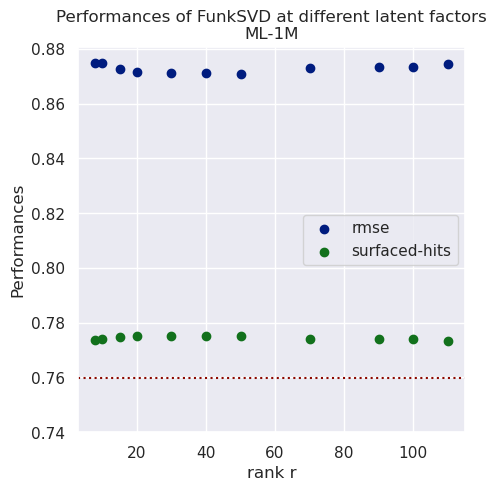

In [23]:
import matplotlib.pyplot as plt


c1={'r':[8,10,15,20,30,40,50,70,90,100,110],
    'rmse':[ds2standards['ml-1m']['SVD8']['rmse'],ds2standards['ml-1m']['SVD10']['rmse'],
            ds2standards['ml-1m']['SVD15']['rmse'],ds2standards['ml-1m']['SVD20']['rmse'],
            ds2standards['ml-1m']['SVD30']['rmse'],ds2standards['ml-1m']['SVD40']['rmse'],
            ds2standards['ml-1m']['SVD50']['rmse'],ds2standards['ml-1m']['SVD70']['rmse'],
            ds2standards['ml-1m']['SVD90']['rmse'],ds2standards['ml-1m']['SVD']['rmse'],
            ds2standards['ml-1m']['SVD110']['rmse']],
   'surfaced-hits':[ds2standards['ml-1m']['SVD8']['surfaced-hits'],ds2standards['ml-1m']['SVD10']['surfaced-hits'],
                    ds2standards['ml-1m']['SVD15']['surfaced-hits'],ds2standards['ml-1m']['SVD20']['surfaced-hits'],
                    ds2standards['ml-1m']['SVD30']['surfaced-hits'],ds2standards['ml-1m']['SVD40']['surfaced-hits'],
                    ds2standards['ml-1m']['SVD50']['surfaced-hits'],ds2standards['ml-1m']['SVD70']['surfaced-hits'],
                    ds2standards['ml-1m']['SVD90']['surfaced-hits'],ds2standards['ml-1m']['SVD']['surfaced-hits'],
                    ds2standards['ml-1m']['SVD110']['surfaced-hits']],
     }
dic=pd.DataFrame(c1)
plt.figure(figsize=(5,5))
plt.scatter(dic['r'],dic['rmse'],color='b',label='rmse')
plt.scatter(dic['r'],dic['surfaced-hits'],color='g',label='surfaced-hits')

plt.axhline(y=ds2standards['ml-1m']['MovieMean']['surfaced-hits'],color='r',linestyle=':')
plt.xlabel("rank r")
plt.ylabel("Performances")
plt.title("Performances of FunkSVD at different latent factors\nML-1M")
plt.yticks(np.arange(0.74, 0.88, step=0.02))
plt.legend()


## Reported results: SVD standard surfaced-hits for ML-1M

In [14]:
round(ds2standards['ml-1m']['SVD']['surfaced-hits'] * 100, 1)

77.4

In [15]:
normalize_hits = False

for df, dataset in [
    (df_1m, 'ml-1m',),
    #(df_20m, 'ml-20m',),
]:
    metric2altalgo = dataset_to_algo_to_metric_to_altalgo[dataset]['SVD']
    # will only work for SVD as its written right now.
    
    #personalization_boost_coefficient
    for pbc in [
        1.1, 1.02, 2, 4, 8,
    ]:
        for old_metric, k in [
            ('prec10t4', 10),
            #('ndcg10', 10),
            # the actual count of 4 star ratings in the whole ds
            ('hits', 1),
            ('totalhits', 1),
            ('normhits', 1)
        ]:
            for group in ['non-boycott', 'all']:
                # name the new dataframe column
                new_metric = '{}boosthits-{}'.format(pbc, old_metric)
                total_possible_hits = num_users[dataset] * k
                if old_metric == 'totalhits':
                    total_possible_hits = ds2standards[dataset]['SVD'][old_metric]
                elif old_metric == 'hits':
                    total_possible_hits = ds2standards[dataset]['SVD'][old_metric] * num_users[dataset]
                
                # boycotting users provide 0 hits. 
                # so with a full boycott, damage = total possible hits
                comparison = -1 * total_possible_hits
                #comparison = -1 * ds2standards[dataset]['SVD'][old_metric] * total_possible_hits

                key_template = 'percent_increase_{}_{}'
                new_key = key_template.format(new_metric, group)

   
                # no missing users in a strike ("All Users" perspective)
                if group == 'all':
                    frac_miss_arr = [0] * len(df.index)
                # there are missing users in a data boycott!
                else:
                    frac_miss_arr = list(df['num_users_boycotting'])

                labor_metric = 'labor-' + new_metric
                consumer_metric = 'consumer-' + new_metric

                # get the predicted diff if we switched to MovieMean
                pred_diff = metric2altalgo[old_metric]['MovieMean']
                # should get more negative as prec_val gets more negative
                #print(pred_diff)
                coefficients = np.polyfit(
                    [pred_diff, 0], # x values
                    [total_possible_hits/pbc - total_possible_hits, 0],# y values
                    1, # polynomial order, i.e. this is a line
                )

                df[key_template.format(labor_metric, group)] = [
                    ( coefficients[1] + coefficients[0] * prec_val  * (1 - frac_miss)) for (
                        prec_val, frac_miss
                    ) in zip(df[key_template.format(old_metric, group)], frac_miss_arr)
                ]
                df[key_template.format(consumer_metric, group)] = [
                    (comparison * frac_miss) for frac_miss in frac_miss_arr
                ]

                df[new_key] = [
                    (labor_power + consumer_power) for (
                        labor_power, consumer_power
                    ) in zip(
                        df[key_template.format('labor-' + new_metric, group)],
                        df[key_template.format('consumer-' + new_metric, group)],
                    )
                ]
                df[new_key.replace('percent_increase_', '')] = [
                    (labor_power + consumer_power + ds2standards[dataset]['SVD']['totalhits']) for (
                        labor_power, consumer_power
                    ) in zip(
                        df[key_template.format('labor-' + new_metric, group)],
                        df[key_template.format('consumer-' + new_metric, group)],
                    )
                ]

                if normalize_hits:
                    print('Normalizing. Will divide hit values by total possible hits.')
                    df[new_key] /= total_possible_hits
                    df[key_template.format(labor_metric, group)] /= total_possible_hits
                    df[key_template.format(consumer_metric, group)] /= total_possible_hits

                for st_al_nm in standard_algo_names:
                    old_val = metric2altalgo[old_metric][st_al_nm]
                    # convert from percent to raw precision change
                    old_val *= ds2standards[dataset]['SVD'][old_metric] / 100
                    # multiply by k and the probability of clicks b/c we want to get from prec@5 to hits
                    if not normalize_hits:
                        old_val *= total_possible_hits
                    metric2altalgo[new_metric][st_al_nm] = old_val
                    metric2altalgo[labor_metric][st_al_nm] = old_val
                    metric2altalgo[consumer_metric][st_al_nm] = old_val
            try:
                df['increase_hit-ratio@{}_non-boycott'.format(k)] = [
                boycott_val / strike_val for (boycott_val, strike_val) in zip(
                    df[key_template.format(new_metric, 'non-boycott')], df[key_template.format(new_metric, 'all')])
            ]
            except ZeroDivisionError:
                df['increase_hit-ratio@{}_non-boycott'.format(k)] = [
                    float("nan") for (boycott_val, strike_val) in zip(
                        df[key_template.format(new_metric, 'non-boycott')], df[key_template.format(new_metric, 'all')])
            ]
            
            
            try:
                df['increase_hit-ratio@{}_all'.format(k)] = [
                boycott_val / strike_val for (boycott_val, strike_val) in zip(
                    df[key_template.format(new_metric, 'non-boycott')], df[key_template.format(new_metric, 'all')])
            ]
            except ZeroDivisionError:
                df['increase_hit-ratio@{}_all'.format(k)] = [
                    float("nan") for (boycott_val, strike_val) in zip(
                        df[key_template.format(new_metric, 'non-boycott')], df[key_template.format(new_metric, 'all')])
            ]   
                
                
            #print(df[['num_users_boycotting', 'increase_hits-prec5t4_non-boycott', 'increase_hits-prec5t4_all', 'increase_hit-ratio@5_non-boycott']])


/tmp/ipykernel_7045/2876807507.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_key.replace('percent_increase_', '')] = [
/tmp/ipykernel_7045/2876807507.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[key_template.format(labor_metric, group)] = [
/tmp/ipykernel_7045/2876807507.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

## Seperate out our data
We want to separate the simuated boycotts into homogenous vs. heterogenous boycotts. We can also check that we have the # of samples and experiment indices that we expect.

# Reported Results: Number of Samples per strike/boycott group

In [16]:


samples_df_1m = df_1m[df_1m['type'] == 'sample_users']
print('\n===Heterogenous Boycotts===\n')
print(samples_df_1m.name.value_counts())
print(samples_df_1m['indices'].value_counts())

org_df = df_1m[df_1m['type'].isin(organized_experiments)]
print('\n===Homogenous Boycotts===\n')
print(org_df.name.value_counts())
print(org_df['indices'].value_counts())



===Heterogenous Boycotts===

1 user sample       10
3 user sample       10
6 user sample       10
30 user sample      10
60 user sample      10
302 user sample     10
604 user sample     10
1208 user sample    10
1812 user sample    10
2416 user sample    10
3020 user sample    10
3624 user sample    10
4228 user sample    10
4832 user sample    10
5436 user sample    10
5980 user sample    10
Name: name, dtype: int64
1-to-10    160
Name: indices, dtype: int64

===Homogenous Boycotts===

male users excluded                10
users from state US_CO excluded    10
users from state US_VA excluded    10
users from state US_AL excluded    10
users from state US_NJ excluded    10
                                   ..
technician/engineer excluded       10
self-employed excluded             10
scientist excluded                 10
sales/marketing excluded           10
users from state US_SD excluded    10
Name: name, Length: 82, dtype: int64
1-to-10    820
Name: indices, dtype: int64


### Bonus analysis: Compare Precision-Estimated Hits to Actual Hits

Here we look at what happens if we use precision to estimate # hits (based on  linear `precision ~ hits` model)


   num_users_boycotting    variable     value
0              0.000166  ndcg10_all  0.793329
1              0.000166  ndcg10_all  0.792782
2              0.000166  ndcg10_all  0.793104
3              0.000166  ndcg10_all  0.793173
4              0.000166  ndcg10_all  0.793883


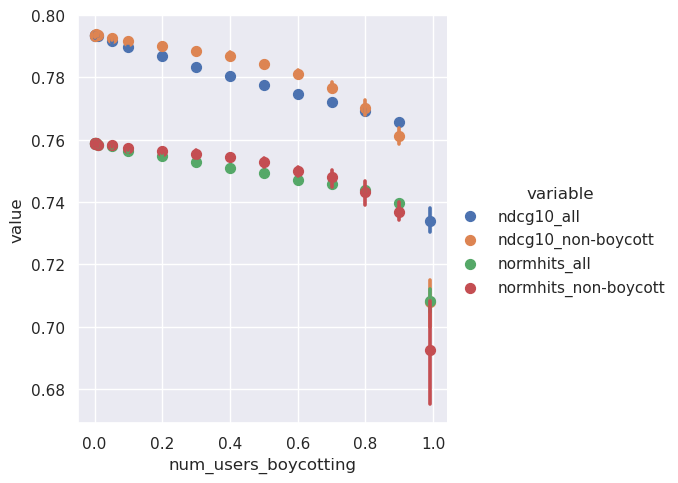

In [17]:
hits_df = samples_df_1m.copy()
hits_df = hits_df[~hits_df.hits_all.isna()]
hits_metric = 'ndcg10'
metric2 = 'normhits'
include = [
    'num_users_boycotting', 
]
hits_cols = [
    '{}_all'.format(hits_metric), 
    '{}_non-boycott'.format(hits_metric),
    #'{}_boycott'.format(hits_metric),
]
# for col in hits_cols:
#     hits_df[col] *= 0.76 / 14.75#num_users['ml-1m']

plot_metric2 = True
include += hits_cols
if plot_metric2:
    cols = [
        '{}_all'.format(metric2), 
        '{}_non-boycott'.format(metric2),
    ]

    include += cols
    
hits_df = hits_df[include].melt(id_vars='num_users_boycotting')
print(hits_df.head())

# for k in hits_df.num_users_boycotting:
#     print(k)
#     matches_from_hits = hits_df[hits_df.num_users_boycotting == k]
#     matches_from_orig = samples_df_1m[hits_df.num_users_boycotting == k]

sns.lmplot(
        x="num_users_boycotting", y="value", hue='variable', data=hits_df,
        fit_reg=False,
        x_estimator=np.mean, ci=99, 
    )
plt.show()

In [18]:
from collections import defaultdict
name2vals = defaultdict(list)

for name, group in hits_df.groupby('num_users_boycotting'):
    #print(name)
    for subname, subgroup in group.groupby('variable'):
        #print(subname, subgroup['value'].mean())
        name2vals[subname].append(subgroup['value'].mean())
        
print(name2vals)

defaultdict(<class 'list'>, {'ndcg10_all': [0.793115487278365, 0.7934451061558454, 0.7934227319000493, 0.7936875722024083, 0.7934128538997864, 0.79152444272635, 0.7897348308767959, 0.7867012575507107, 0.783426094975329, 0.7805080150570998, 0.7776380984841815, 0.7747596733044487, 0.7720831407824115, 0.7693461711968183, 0.7656072546732006, 0.7339847191334326], 'ndcg10_non-boycott': [0.7931132713382277, 0.7934636447115437, 0.7934498749914158, 0.7937835281142444, 0.7935966061767661, 0.7924789305183724, 0.7915909604653707, 0.7901277099617873, 0.7883727649052135, 0.7868811324119835, 0.7843020496004486, 0.7811781392308008, 0.7765598815651987, 0.7700911473482518, 0.7613006369551918, 0.7080146322912656], 'normhits_all': [0.758979768193664, 0.7588261757242372, 0.7587093068055505, 0.7588498577014123, 0.7581743370619396, 0.7577991448191114, 0.756440908247008, 0.7547932411973423, 0.7527710128670543, 0.7510002201256674, 0.7493958932571856, 0.7469141742676717, 0.745648529119127, 0.7436952427881107, 0

### Do two metrics correlate?

In [19]:
from scipy.stats import pearsonr, spearmanr

try:
    for group in [
        'all', 'non-boycott',
    ]:
        x = '{}_{}'.format(hits_metric,group)
        y = '{}_{}'.format(metric2, group)
        print(x, y)
        print(pearsonr(name2vals[x], name2vals[y]))
#         plt.plot(name2vals[x], name2vals[y])
#     plt.show()
except Exception as err:
    print(err)
    pass

ndcg10_all normhits_all
(0.9884672694497358, 7.058040244168504e-13)
ndcg10_non-boycott normhits_non-boycott
(0.9981998466373928, 1.6347482882467271e-18)


## Clean up the homogenous boycott "name" columns
This is helpful because our homogenous boycott plots are going to very cluttered. We want to remove as much text as possible without making the plots confusing.

In [20]:
org_df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('using threshold 4', '')
    .strip()
    .lower()
    for x in list(org_df.name)
]
# can ignore the below warning, the code in this cell works

/tmp/ipykernel_7045/4129003958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  org_df.name = [


In [21]:
import p_b_curve
import importlib
importlib.reload(p_b_curve)
plot = p_b_curve.p_b_curve

template = 'Effect on {}, {}'

# Reported Results: Surfaced hits under 30% boycott and strike

In [22]:
df, ds = samples_df_1m, 'ml-1m'
print('Boycott:', round(df[(df.algo_name == 'SVD') & (df.name == '1812 user sample')]['surfaced-hits_non-boycott'].mean() * 100, 1))
print('Strike:', round(df[(df.algo_name == 'SVD') & (df.name == '1812 user sample')]['surfaced-hits_all'].mean() * 100, 1))

Boycott: 53.8
Strike: 76.7


# Reported Results: Surfaced hits, normalized relative to MovieMean (un-personalized) under 30% boycott and strike

In [23]:
df, ds = samples_df_1m, 'ml-1m'
print('ML-1M')
pers = ds2standards['ml-1m']['MovieMean']['surfaced-hits'] - ds2standards['ml-1m']['SVD']['surfaced-hits']
print('Boycott:', round(df[(df.algo_name == 'SVD') & (df.name == '1812 user sample')]['increase_surfaced-hits_non-boycott'].mean() / pers * 100, 2))
print('Strike:', round(df[(df.algo_name == 'SVD') & (df.name == '1812 user sample')]['increase_surfaced-hits_all'].mean() / pers * 100, 2))



ML-1M
Boycott: 17.12
Strike: 49.01


# Worked Example at 30% strike

In [24]:
# Look at ml-1m
df, ds = samples_df_1m, 'ml-1m'
diff = ds2standards[ds]['MovieMean']['surfaced-hits'] - ds2standards[ds]['SVD']['surfaced-hits']
print('The difference between personalized (SVD, full data) and un-personalized (item mean, full data) is:', diff)
per_diff = (diff) / ds2standards[ds]['SVD']['surfaced-hits'] * 100
print('The percent difference between personalized and un-personalized is:', per_diff)

# Restrict df to SVD and 1812 user sample (30% of ML-1M)
filt = df[(df.algo_name == 'SVD') & (df.name == '1812 user sample')]


# Print all the #'s as percents rounded to one decimal.'
def represent(x):
    return round(x * 100, 3)

# get the raw #'s'
raw = {
    'participants': represent(filt['surfaced-hits_boycott'].mean()),
    'non-participants': represent(filt['surfaced-hits_non-boycott'].mean()),
    'all': represent(filt['surfaced-hits_all'].mean()),
}
print('raw hit numbers')
print(raw)

assert raw['participants'] + raw['non-participants'] == raw['all']

st = {
    'participants': represent(filt['standards_surfaced-hits_boycott'].mean()),
    'non-participants': represent(filt['standards_surfaced-hits_non-boycott'].mean()),
    'all': represent(filt['standards_surfaced-hits_all'].mean()),
}
print('standards (no campaign) hit numbers')
print(st)

# get the change
inc = {
    'participants': represent(filt['increase_surfaced-hits_boycott'].mean()),
    'non-participants': represent(filt['increase_surfaced-hits_non-boycott'].mean()),
    'all': represent(filt['increase_surfaced-hits_all'].mean()),
}
print('Change in hit numbers')
print(inc)

#print(inc['participants'], st['participants'], raw['participants'], round(raw['participants'] - st['participants'], 3))

norm_inc = {
    'participants': represent(filt['increase_surfaced-hits_boycott'].mean() / diff),
    'non-participants': represent(filt['increase_surfaced-hits_non-boycott'].mean() / diff),
    'all': represent(filt['increase_surfaced-hits_all'].mean() / diff),
}
print('normalized')
print(norm_inc)

# now get the *percent* change
per_inc = {
    'participants': represent(filt['percent_increase_surfaced-hits_boycott'].mean() / 100),
    'non-participants': represent(filt['percent_increase_surfaced-hits_non-boycott'].mean() / 100),
    'all': represent(filt['percent_increase_surfaced-hits_all'].mean() / 100),
}
print('Percent change in hit numbers')
print(per_inc)

norm_per_inc = {
    'participants': represent(filt['percent_increase_surfaced-hits_boycott'].mean() / per_diff),
    'non-participants': represent(filt['percent_increase_surfaced-hits_non-boycott'].mean() / per_diff),
    'all': represent(filt['percent_increase_surfaced-hits_all'].mean() / per_diff),
}
print('Normalized percent change in hit numbers')
print(norm_per_inc)

The difference between personalized (SVD, full data) and un-personalized (item mean, full data) is: -0.014048786592986806
The percent difference between personalized and un-personalized is: -1.8152497147529003
raw hit numbers
{'participants': 22.865, 'non-participants': 53.84, 'all': 76.705}
standards (no campaign) hit numbers
{'participants': 23.312, 'non-participants': 54.081, 'all': 77.393}
Change in hit numbers
{'participants': -0.448, 'non-participants': -0.241, 'all': -0.688}
normalized
{'participants': 31.886, 'non-participants': 17.12, 'all': 49.005}
Percent change in hit numbers
{'participants': -1.921, 'non-participants': -0.445, 'all': -0.89}
Normalized percent change in hit numbers
{'participants': 105.816, 'non-participants': 24.499, 'all': 49.005}


In [25]:
d = {
    '0) baseline': st,
    '1) SH after strike': raw,
    '2) change in SH': inc,
    '3) change in SH, normalized w.r.t un-personalized': norm_inc,
    '4) % change in SH': per_inc,
    '5) % change in SH, normalized w.r.t un-personalized': norm_per_inc,
}
ex1 = pd.DataFrame.from_dict(d, orient='index')
ex1 = ex1.rename(index=str, columns={
    'participants': 'strikers',
    'non-participants': 'non-strikers',
    'all': 'everyone'
})
ex1.to_csv('ex1.csv')
ex1

,strikers,non-strikers,everyone
0) baseline,23.312,54.081,77.393
1) SH after strike,22.865,53.840,76.705
2) change in SH,-0.448,-0.241,-0.688
"3) change in SH, normalized w.r.t un-personalized",31.886,17.120,49.005
4) % change in SH,-1.921,-0.445,-0.890
"5) % change in SH, normalized w.r.t un-personalized",105.816,24.499,49.005


In [26]:
-0.448 / 23.312 * 100

-1.9217570350034316

In [27]:
filt['num_ratings']

80    708596
81    703286
82    696262
83    694165
84    696169
85    701789
86    700886
87    687363
88    703935
89    709287
Name: num_ratings, dtype: int64

# Reported Results: Figure 2, Left

ML-1m Surfaced Hits vs. Size

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:0.76704671282382  |  ALL val:0.76704671282382
ratio_nb: -0.42255713172125947  |  ratio_all:-0.42255713172125947
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: 0.76704671282382}})


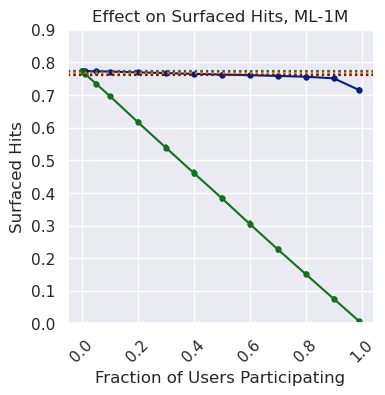

In [28]:
# Fig. 1, Upper Left
df, ds = samples_df_1m, 'ml-1m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'surfaced-hits',
        #'normhits',
    ],
    groups=[
        'all', 'non-boycott', 
        #'standards_non-boycott'
    ],
    legend=False, 
    ylabel='Surfaced Hits',
    title_template=template,
    height=4, aspect=1,
    line_names = ['SVD', 'MovieMean', 'KNNBaseline_item_msd'],
    print_vals=[0.3],
    ylim=(0, 0.9),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_surfacedhits.png', bbox_inches='tight', dpi=300)
plt.show()

# Reported results: Figure 3, left

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:0.76704671282382  |  ALL val:0.76704671282382
ratio_nb: -0.42255713172125947  |  ratio_all:-0.42255713172125947
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: 0.76704671282382}})


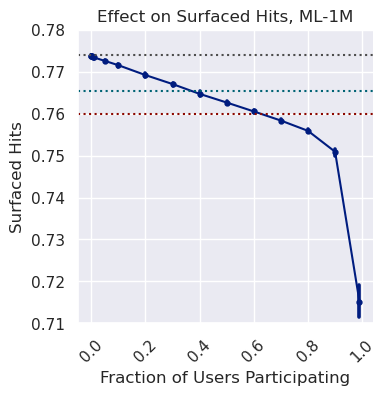

In [29]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
df, ds = samples_df_1m, 'ml-1m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
        'surfaced-hits',
    ],
    groups=[
        'all', 
    ],
    legend=False, 
    ylabel="Surfaced Hits",
    title_template=template,
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    ylim=(0.71, 0.78),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_surfacedhits_zoomed.png', bbox_inches='tight', dpi=300)
plt.show()

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:-0.49005196733481987  |  ALL val:-0.49005196733481987
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: -0.49005196733481987}})


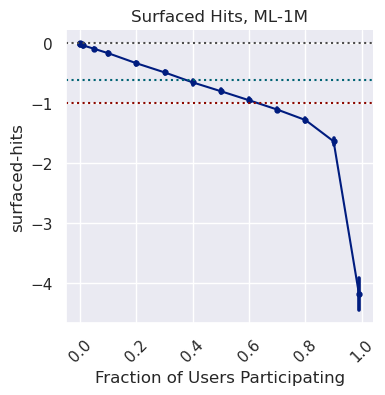

In [30]:
# ML-1M surfaced hits, normalized
df, ds = samples_df_1m, 'ml-1m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=True, normalize=True,
    metrics=[
        'surfaced-hits',
    ],
    groups=[
        'all', 
    ],
    legend=False, 
    ylabel="surfaced-hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    print_vals=[0.3],
    #ylim=(0.71, 0.78),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_surfacedhits_zoomed.png', bbox_inches='tight', dpi=300)
plt.show()

In [31]:
# Set colors for below "boost coefficient" plots

pinks = {}
pinks[2] = '#f8bbd0'
pinks[3] = '#f48fb1'
pinks[4] = '#f06292'
pinks[5] = '#ec407a'
pinks[6] = '#e91e63'
pinks[7] = '#d81b60'

purples = {}
purples[2] = '#e1bee7'
purples[3] = '#ce93d8'
purples[4] = '#ba68c8'
purples[5] = '#ab47bc'
purples[6] = '#9c27b0'
purples[7] = '#8e24aa'
#https://material.io/tools/color/#!/?view.left=0&view.right=0&primary.color=E1BEE7

## Look at how total hits changes under the "boost coefficient" model

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


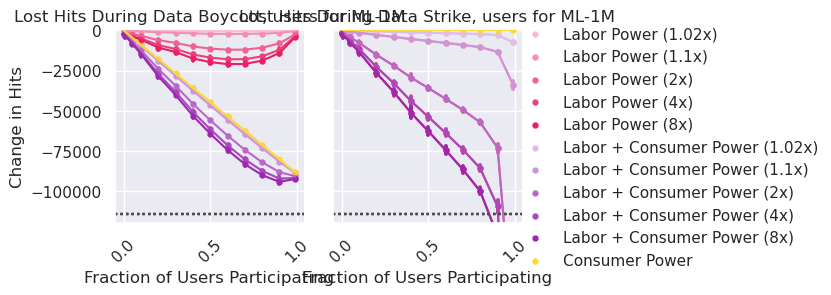

In [32]:
metric = 'totalhits'
_ = plot(
    samples_df_1m[samples_df_1m.algo_name == 'SVD'], 'ml-1m',
    show_interp=False,
    increase=True, percents=True, normalize=False,
    metrics=[
        '1.02boosthits-{}'.format(metric),
        '1.1boosthits-{}'.format(metric),
        '2boosthits-{}'.format(metric),
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        
        'labor-1.02boosthits-{}'.format(metric),
        'labor-1.1boosthits-{}'.format(metric),
        'labor-2boosthits-{}'.format(metric),
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),  
    ],
    groups=['all', 'non-boycott'],
    #hue='metric', col='group', row='algo_name',
    hue='metric', col='group', row='algo_name',
    
    legend=True, 
    ylabel='Change in Hits',
    title_template='Lost Hits During {} for {}',
    height=3, aspect=1,
    label_map={
        'labor-1.02boosthits-{}'.format(metric): 'Labor Power (1.02x)', 
        'labor-1.1boosthits-{}'.format(metric): 'Labor Power (1.1x)', 
        'labor-2boosthits-{}'.format(metric):  'Labor Power (2x)', 
        'labor-4boosthits-{}'.format(metric): 'Labor Power (4x)',
        'labor-8boosthits-{}'.format(metric): 'Labor Power (8x)',

        '1.02boosthits-{}'.format(metric): 'Labor + Consumer Power (1.02x)', 
        '1.1boosthits-{}'.format(metric): 'Labor + Consumer Power (1.1x)', 
        '2boosthits-{}'.format(metric): 'Labor + Consumer Power (2x)', 
        '4boosthits-{}'.format(metric): 'Labor + Consumer Power (4x)',
        '8boosthits-{}'.format(metric): 'Labor + Consumer Power (8x)',

        'consumer-1.1boosthits-{}'.format(metric): 'Consumer Power',
    },
    hue_order = [
        'labor-1.02boosthits-{}'.format(metric), 
        'labor-1.1boosthits-{}'.format(metric) ,
        'labor-2boosthits-{}'.format(metric), 
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),

        '1.02boosthits-{}'.format(metric), 
        '1.1boosthits-{}'.format(metric), 
        '2boosthits-{}'.format(metric), 
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),
    ],
    palette={
        'labor-1.02boosthits-{}'.format(metric): pinks[2], 
        'labor-1.1boosthits-{}'.format(metric): pinks[3], 
        'labor-2boosthits-{}'.format(metric):  pinks[4], 
        'labor-4boosthits-{}'.format(metric): pinks[5],
        'labor-8boosthits-{}'.format(metric): pinks[6],
        
        '1.02boosthits-{}'.format(metric): purples[2], 
        '1.1boosthits-{}'.format(metric): purples[3], 
        '2boosthits-{}'.format(metric):  purples[4], 
        '4boosthits-{}'.format(metric): purples[5],
        '8boosthits-{}'.format(metric): purples[6],
        
        'consumer-1.1boosthits-{}'.format(metric): '#fdd835',
    },
    plot_horiz_lines=True,
    line_names=['MaxDamage',], ylim=(-120000, 500),
    print_vals=None,
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo['ml-1m'],
    id_vars=id_vars,
    ds2standards=ds2standards
)
#plt.ylim(-114000, 200)
plt.savefig('ml-1m_totalhits.png', bbox_inches='tight', dpi=300)
plt.show()


metric = 'totalhits'
df = samples_df_20m
ds = 'ml-20m'
_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=True, normalize=False,
    metrics=[
        '1.02boosthits-{}'.format(metric),
        '1.1boosthits-{}'.format(metric),
        '2boosthits-{}'.format(metric),
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        
        'labor-1.02boosthits-{}'.format(metric),
        'labor-1.1boosthits-{}'.format(metric),
        'labor-2boosthits-{}'.format(metric),
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),  
    ],
    groups=['all', 'non-boycott'],
    #hue='metric', col='group', row='algo_name',
    hue='metric', col='group', row='algo_name',
    
    legend=True, 
    ylabel='Change in Hits',
    title_template='Lost Hits During {} for {}',
    height=4, aspect=1,
    label_map={
        'labor-1.02boosthits-{}'.format(metric): 'Labor Power (1.02x)', 
        'labor-1.1boosthits-{}'.format(metric): 'Labor Power (1.1x)', 
        'labor-2boosthits-{}'.format(metric):  'Labor Power (2x)', 
        'labor-4boosthits-{}'.format(metric): 'Labor Power (4x)',
        'labor-8boosthits-{}'.format(metric): 'Labor Power (8x)',

        '1.02boosthits-{}'.format(metric): 'Labor + Consumer Power (1.02x)', 
        '1.1boosthits-{}'.format(metric): 'Labor + Consumer Power (1.1x)', 
        '2boosthits-{}'.format(metric): 'Labor + Consumer Power (2x)', 
        '4boosthits-{}'.format(metric): 'Labor + Consumer Power (4x)',
        '8boosthits-{}'.format(metric): 'Labor + Consumer Power (8x)',

        'consumer-1.1boosthits-{}'.format(metric): 'Consumer Power',
    },
    hue_order = [
        'labor-1.02boosthits-{}'.format(metric), 
        'labor-1.1boosthits-{}'.format(metric) ,
        'labor-2boosthits-{}'.format(metric), 
        'labor-4boosthits-{}'.format(metric),
        'labor-8boosthits-{}'.format(metric),

        '1.02boosthits-{}'.format(metric), 
        '1.1boosthits-{}'.format(metric), 
        '2boosthits-{}'.format(metric), 
        '4boosthits-{}'.format(metric),
        '8boosthits-{}'.format(metric),
        'consumer-1.1boosthits-{}'.format(metric),
    ],
    palette={
        'labor-1.02boosthits-{}'.format(metric): pinks[2], 
        'labor-1.1boosthits-{}'.format(metric): pinks[3], 
        'labor-2boosthits-{}'.format(metric):  pinks[4], 
        'labor-4boosthits-{}'.format(metric): pinks[5],
        'labor-8boosthits-{}'.format(metric): pinks[6],
        
        '1.02boosthits-{}'.format(metric): purples[2], 
        '1.1boosthits-{}'.format(metric): purples[3], 
        '2boosthits-{}'.format(metric):  purples[4], 
        '4boosthits-{}'.format(metric): purples[5],
        '8boosthits-{}'.format(metric): purples[6],
        
        'consumer-1.1boosthits-{}'.format(metric): '#fdd835',
    },
    plot_horiz_lines=True,
    line_names=['MaxDamage',], 
    #ylim=(-120000, 500),
    print_vals=None,
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)
#plt.ylim(-114000, 200)
plt.savefig('ml-1m_complicatedhits.svg', bbox_inches='tight', dpi=300)
plt.show()


# Bonus results: All metrics

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


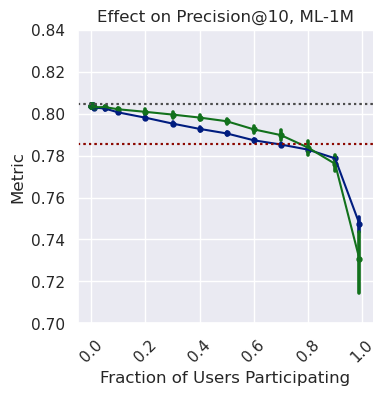

In [33]:
df, ds = samples_df_1m, 'ml-1m'

_ = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=False, percents=False, normalize=False,
    metrics=[
#        'rmse',
#         'ndcg10',
#         'ndcg5',
#         'tailndcg10',
#         'ndcgfull',
        'prec10t4',
#         'rec10t4',
#         'prec5t4',
#         'rec5t4',
#         'tailprec10t4',
#         'tailrec10t4',
        #'normhits',
    ],
    groups=[
        'all', 'non-boycott', 
        #'standards_non-boycott'
    ],
    legend=False, 
    ylabel='Metric',
    title_template=template,
    height=4, aspect=1,
    line_names = ['SVD', 'MovieMean',],
    print_vals=[],
    ylim=(0.70, 0.84),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_othermetrics.png', bbox_inches='tight', dpi=300)
plt.show()

In [34]:
import p_b_curve
import importlib
importlib.reload(p_b_curve)
plot = p_b_curve.p_b_curve

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:-0.006884635508560224  |  ALL val:-0.006884635508560224
Algo:SVD  |  Metric:totalhits  |  #users:0.3
NB Val:-792.1200000000069  |  ALL val:-792.1200000000069
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: -396.06344231775773}})


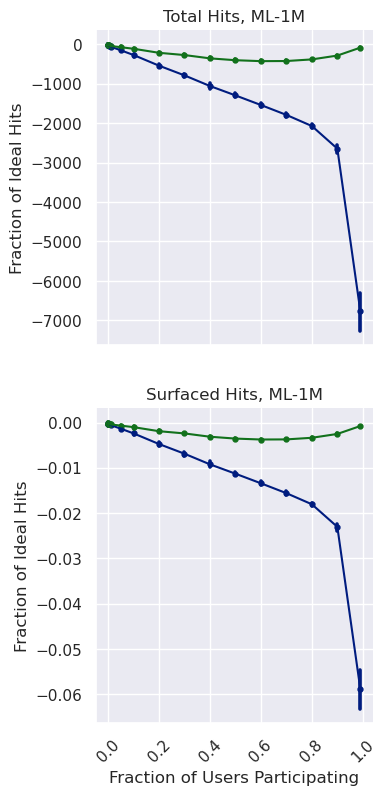

In [35]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
USE_PERCENTS = 0
USE_INCREASE = 1
NORMALIZE = 0


df, ds = samples_df_1m, 'ml-1m'

perinc_algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=USE_INCREASE, percents=USE_PERCENTS, normalize=NORMALIZE,
    metrics=[
        'surfaced-hits',
        'totalhits',
    ],
    groups=[
        'non-boycott', 'all',
    ],
    legend=False, 
    ylabel="Fraction of Ideal Hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        #'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        #'MovieMean'
    ],
    print_vals=[0.3],
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_percentchange.png', bbox_inches='tight', dpi=300)
plt.show()

## Compute the 'algo_to_metric_to_group_to' for 1m in percent change

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:-0.8895666939186293  |  ALL val:-0.8895666939186293
Algo:SVD  |  Metric:totalhits  |  #users:0.3
NB Val:-0.8895666939186293  |  ALL val:-0.8895666939186293
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: -0.8895666939186293}})


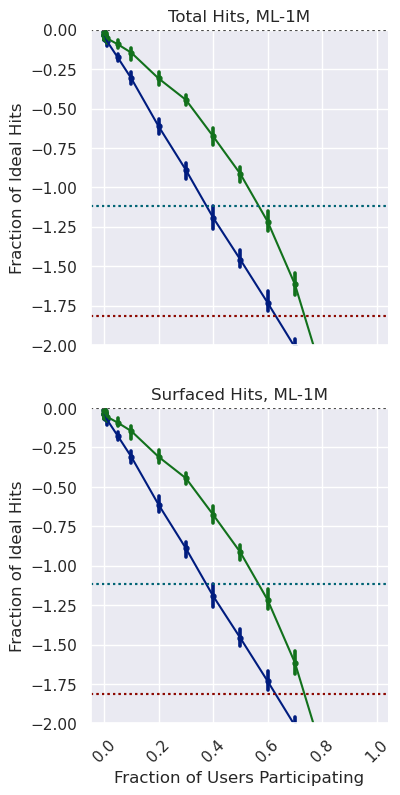

In [36]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
USE_PERCENTS = 1
USE_INCREASE = 1
NORMALIZE = 0


df, ds = samples_df_1m, 'ml-1m'

perinc_algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=USE_INCREASE, percents=USE_PERCENTS, normalize=NORMALIZE,
    metrics=[
        'surfaced-hits',
        'totalhits',
    ],
    groups=[
        'non-boycott', 'all',
    ],
    legend=False, 
    ylabel="Fraction of Ideal Hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    ylim=(-2.0, 0.0),
    print_vals=[0.3],
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_percentchange.png', bbox_inches='tight', dpi=300)
plt.show()

## Compute the 'algo_to_metric_to_group_to' for 1m in normalized percent change

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Algo:SVD  |  Metric:ndcg10  |  #users:0.3
NB Val:-0.4901181793433008  |  ALL val:-0.4901181793433008
Algo:SVD  |  Metric:surfaced-hits  |  #users:0.3
NB Val:-0.49005196733481987  |  ALL val:-0.49005196733481987
Algo:SVD  |  Metric:totalhits  |  #users:0.3
NB Val:-0.49005196733481987  |  ALL val:-0.49005196733481987
=====
Size to Mean Decrease
defaultdict(<class 'dict'>, {'SVD': {0.3: -0.49007403800431354}})


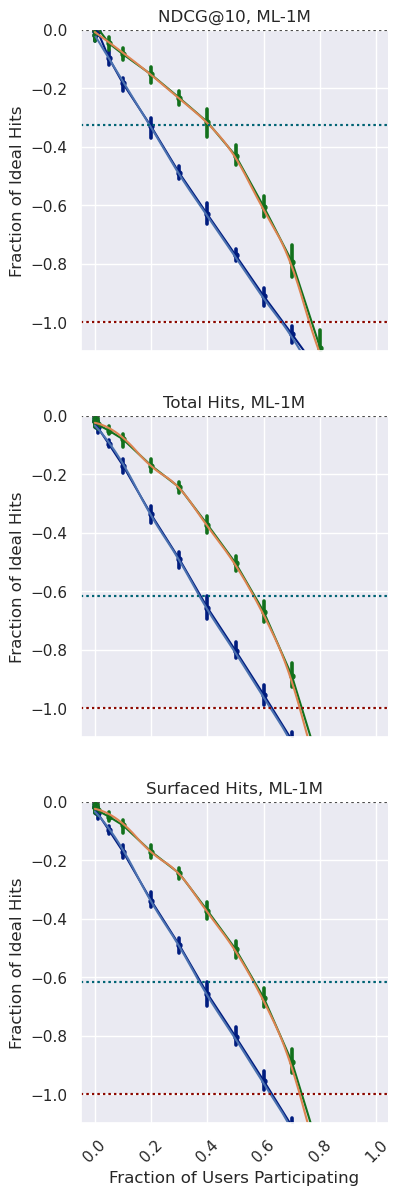

In [37]:
# Show Frac Ideal Hits from the Perspective of Remaining Users
USE_PERCENTS = 1
USE_INCREASE = 1
NORMALIZE = 1

df, ds = samples_df_1m, 'ml-1m'

algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=True,
    increase=USE_INCREASE, percents=USE_PERCENTS, normalize=NORMALIZE,
    metrics=[
        'ndcg10', 
        #'normhits',
        'surfaced-hits',
        #'ndcgfull',
        'totalhits'
    ],
    groups=[
        'non-boycott', 'all',
    ],
    legend=False, 
    ylabel="Fraction of Ideal Hits",
    title_template='{}, {}',
    height=4, aspect=1,
    line_names=[
        'SVD', 'KNNBasic_item_msd', 
        #'KNNBaseline_item_msd', 
        #'KNNBasic_user_msd', 
        'MovieMean'
    ],
    ylim=(-1.1, 0),
    print_vals=[0.3],
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

plt.savefig(ds + '_norm.png', bbox_inches='tight', dpi=300)
plt.show()

In [38]:
metric = 'totalhits'
metric = 'surfaced-hits'
# comparisons = ds2standards['ml-1m']
# comparisons = {
#     key: comparisons[key].get(metric, 0) for key in comparisons.keys()
# }
comparisons = dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]
#movie_val = -1 * dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean']
for group in [
    'all', 
    #'non-boycott'
]:
    found_item, found_user = False, False
    found_itembasic = False
    for x in range(0, num_ratings['ml-1m'], int(num_ratings['ml-1m'] / 10000)):
        y = perinc_algo_to_metric_to_group_to['SVD'][metric][group]['interp_ratings'](x)
        #print(x,y)
        #print(comparisons['KNNBasic_item_msd'])

#         if not found_item:
#             if y <= comparisons['KNNBaseline_item_msd']:
#                 print(group + ' found item:')
#                 print(x / num_ratings['ml-1m'])
#                 found_item = True
#         if not found_user:
#             if y <= comparisons['KNNBasic_user_msd']:
#                 print(group + ' found user')
#                 print(x / num_ratings['ml-1m'])
#                 found_user = True
        if not found_itembasic:
            if y <= comparisons['KNNBasic_item_msd']:
                print(group + ' found knnbasicitem')
                print(x / num_ratings['ml-1m'])
                found_itembasic = True

all found knnbasicitem
0.3742217876463819


In [39]:
xvals = np.array(range(0, num_ratings['ml-1m'], int(num_ratings['ml-1m'] / 10000)))
arr = abs(perinc_algo_to_metric_to_group_to['SVD']['surfaced-hits']['all']['interp_ratings'](xvals) - comparisons['KNNBasic_item_msd'])
x = np.argmin(arr)
xvals[x]/1e6*100


37.419999999999995

/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


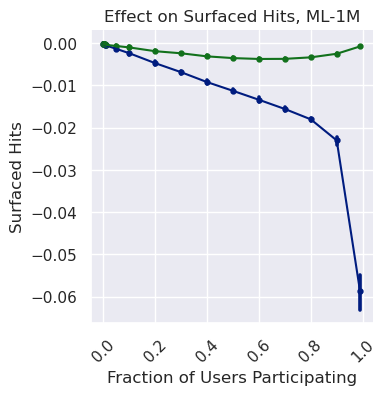

In [40]:
df, ds = samples_df_1m, 'ml-1m'

inc_algo_to_metric_to_group_to = plot(
    df[df.algo_name == 'SVD'], ds,
    show_interp=False,
    increase=True, percents=False, normalize=False,
    metrics=[
        'surfaced-hits',
        #'normhits',
    ],
    groups=[
        'all', 'non-boycott', 
        #'standards_non-boycott'
    ],
    legend=False, 
    ylabel='Surfaced Hits',
    title_template=template,
    height=4, aspect=1,
    line_names = [
        #'SVD', 'MovieMean', 'GlobalMean'
    ],
    print_vals=[],
    #ylim=(0, 0.8),
    algo2metric2altalgo=dataset_to_algo_to_metric_to_altalgo[ds],
    id_vars=id_vars,
    ds2standards=ds2standards
)

#plt.savefig(ds + '_surfacedhits.png', bbox_inches='tight', dpi=300)
plt.show()

# Reported Results: Effects relative to non-personalized results
## First look at the relative change in surfaced hit for non-participants

In [41]:
# effects on non-participants, normalized 
d1= {}
group = 'non-boycott'
print(group)
d1['30percent_boycott_ml-1m'] = round(algo_to_metric_to_group_to['SVD']['surfaced-hits'][group]['interp_ratings'](0.3 * num_ratings['ml-1m']) * 100, 1)

#d1['30percent_boycott_ml-1m_ndcg10'] = round(algo_to_metric_to_group_to['SVD']['ndcg10'][group]['interp_ratings'](0.3 * num_ratings['ml-1m']) * 100, 1)

pprint(d1)



non-boycott
{'30percent_boycott_ml-1m': -24.5}


In [42]:
round(algo_to_metric_to_group_to['SVD']['surfaced-hits']['non-boycott']['interp_ratings'](299826.82) * 100, 3)

-24.482

In [43]:
d2 = {}
group = 'all'
print(group)
d2['30percent_strike_ml-1m'] = round(algo_to_metric_to_group_to['SVD']['surfaced-hits'][group]['interp_ratings'](0.3 * num_ratings['ml-1m']) * 100, 1)
d2['37.5percent_strike_ml-1m'] = round(algo_to_metric_to_group_to['SVD']['surfaced-hits'][group]['interp_ratings'](0.375 * num_ratings['ml-1m']) * 100, 1)

pprint(d2)

all
{'30percent_strike_ml-1m': -49.0, '37.5percent_strike_ml-1m': -61.6}


## Let's look at the change in surfaced hits for the perspective of non-participants (marked "non-boycott")

In [44]:
d3 = {}
group = 'non-boycott'
d3['30_ml-1m'] = round(inc_algo_to_metric_to_group_to['SVD']['surfaced-hits'][group]['interp_ratings'](0.3 * num_ratings['ml-1m']) * 100, 4)

pprint(d3)

{'30_ml-1m': -0.2405}


# Homogenous (i.e. Targeted/Focus/shared-characteristic) Boycotts

In [45]:
def Partial_users(df):
    return df[(
        (df.userfrac == 0.7) & (df.ratingfrac == 1.0) 
        #& (df.algo_name == 'SVD')
    )]

In [46]:
def Partial_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 0.7)
    )]

In [47]:
def all_users_all_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 1.0)
    )]

In [48]:

#metrics += ['hits-prec5t4', 'labor-hits-prec5t4', 'consumer-hits-prec5t4']

metrics = [
    #'surfaced-hits', 
    'totalhits'
]

# warning: you probably do not want to change these (unless you're sure)
NORMALIZE = 0
USE_PERCENTS = 1
USE_INCREASE = 1

copy_org_df = org_df.copy()
if NORMALIZE:
    for metric in metrics:
        for algo_name in algo_names:
            movie_val = abs(dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean'])
            for group in ['non-boycott', 'like-boycott', 'not-like-boycott']:
                col = 'percent_increase_{}_{}'.format(metric, group)

                copy_org_df.loc[
                    copy_org_df.algo_name == algo_name, col
                ] = org_df.loc[org_df.algo_name == algo_name, col] / movie_val
                
for metric in metrics:
    expec = []
    col = '{}_expected'.format(metric)
    if USE_INCREASE:
        col = 'increase_' + col
    if USE_PERCENTS:
        col = 'percent_' + col
    for i, row in copy_org_df.iterrows():
        x = row.num_ratings_missing
        expec.append(float(perinc_algo_to_metric_to_group_to[row.algo_name][metric]['non-boycott']['interp_ratings'](x)))
    kwargs = {col: expec}
    copy_org_df = copy_org_df.assign(**kwargs)

## LB = like-boycott
### So lbless is the number cases where the like boycott performance change was less than expected

In [49]:
from p_b_curve import select_cols, fill_in_longform
ylabel = 'ylabel'

def plot2(
        df, metrics, groups,
        increase=False, percents=False, kind='bar', height=4, flip=False, filename='tmp.svg', save=False,
        palette=None, aspect=1
    ):
    """
    Plots the results of homogenous boycotts
    e.g. 50% of Comedy fans boycott together
    """
    print('len of df (number of experiments included)', len(df.index))
    for name in list(set(df.name)):
#        tmp = df[df.name == name].num_ratings_missing.mean()
        tmp = df[df.name == name].num_users_boycotting.mean()
        print('Num users boycotting: {}. As a percent: {}'.format(tmp, tmp*100))
#         print('name', name)
#         print('mean number of ratings missing', tmp)pl
#         print(algo_to_metric_to_group_to['SVD']['ndcg10']['non-boycott']['interp_ratings'](tmp))
    increase_cols = select_cols(list(df.columns.values), metrics, groups, increase=increase, percents=percents)
    increase_cols = [x for x in increase_cols if 'vanilla' not in x]
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)
    if flip:
        x = "name"
        y = "value"
    else:
        x = "value"
        y = "name"
    if '?' in filename:
        legend = False
    else:
        legend = True
    grid = sns.catplot(
        x=x, y=y, hue="group", data=longform,
        height=height, kind=kind, col='algo_name', row='metric',
        sharex=False,
        row_order=metrics,
        legend=legend,
        legend_out=True,
        palette=palette,
        aspect=aspect
    )
    a = grid.axes
    
    name_to_ratios = defaultdict(list)
    diffs = defaultdict(dict)
    ratios = defaultdict(dict)
    vals = defaultdict(dict)
    name_to_counts = defaultdict(lambda: defaultdict(int))
    
    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        if grid.hue_names:
            group = grid.hue_names[i_hue]        
        
        if NORMALIZE:
            val = -1
        else:
            val = abs(dataset_to_algo_to_metric_to_altalgo['ml-1m']['SVD'][metric]['MovieMean'])
        
        if flip:
            grid.axes[i_row, i_col].axhline(0, color='0.7', linestyle='-')
        else:
            grid.axes[i_row, i_col].axvline(0, color='0.7', linestyle='-')
            grid.axes[i_row, i_col].axvline(val, color='0.7', linestyle='-')
        
        cols = {}
        for col in increase_cols:
            if metric == col.split('_')[-2]:
                
                if 'expected' in col:
                    cols['expec'] = col
                if 'not-like' in col:
                    cols['not-like'] = col
                elif 'non-boycott' in col:
                    cols['nb'] = col
                elif 'like-boycott' in col:
                    cols['lb'] = col
        for name in list(set(longform.name)):
            mask = (
                (longform.metric == metric) &
                (longform.algo_name == algo_name) &
                (longform.name == name)
            )
            
            masked = longform[mask]
            try:
                arrs = {}
                print(cols)
                for key in cols:
                    arrs[key] = np.array(masked[masked.increase_type == cols[key]].value)
                
                means = {key: np.mean(arrs[key]) for key in arrs}
                print(means)
                
                ratio = means['nb'] / means['expec']
                diff = means['nb'] - means['expec']
                
                lb_diff = means['lb'] / np.mean(np.array(masked.num_users_boycotting))#- means['not-like']
                lb_ratio = means['lb'] / means['not-like']

                pval = stats.ttest_ind(arrs['expec'],arrs['nb'], equal_var=False).pvalue                
                name_to_counts[name]['total'] += 1
                
                print('{} {} {}, {}, {}'.format(metric, algo_name, name, cols['expec'], cols['nb']))
                print('Ratio: {}, pval: {}'.format(ratio, pval))
                print('LB to NB ratio: {}'.format(lb_ratio))
                print('lb_diff, mean_lb - mean_nl', lb_diff)
                print('pos = lb has more hits')
                name_to_ratios[name].append(ratio)
                diffs['nb'][name] = diff
                diffs['lb'][name] = lb_diff
                
                ratios['nb'][name] = ratio
                ratios['lb'][name] = lb_ratio
                
                vals['nb'][name] = means['nb']
                vals['lb'][name] = means['lb']
                vals['not-like'][name] = means['not-like']
                
                if pval < 0.5:
                    name_to_counts[name]['total_sig'] += 1

                if diff < 0:
                    name_to_counts[name]['total_less'] += 1
                else:
                    name_to_counts[name]['total_more'] += 1
                #print('lb info', lb_diff, lb_mean, nb_mean)
                if lb_diff < 0:
                    name_to_counts[name]['total_lbless'] += 1
            except Exception as err:
                print(err)
                print(algo_name, metric)
    total = 0
    total_sig = 0
    total_less = 0
    total_more = 0
    total_lbless = 0
    
    for name, counts in name_to_counts.items():
        total += counts['total']
        total_sig += counts['total_sig']
        total_less += counts['total_less']
        total_more += counts['total_more']
        total_lbless += counts['total_lbless']

    print('Totals:')
    print('{} lbless, {} sig, {} less, and {} more out of {} total'.format(
            total_lbless, total_sig, total_less,
            total_more, total)
        )
    if save:
        new_labels = ['Similar Users', 'Not Participating\n Users', 'Expected']
        for t, l in zip(grid._legend.texts, new_labels): t.set_text(l)
        if 'h2' in filename:
            grid.set_ylabels("")
        else:
            grid.set_ylabels(ylabel)
        grid.set_xlabels("")
        grid.set_titles("")
        plt.savefig(filename, size=(3, 3), bbox_inches='tight', dpi=300)
    return grid, (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals)


In [50]:
palette={'all': 'b', 'non-boycott': 'g', 'expected': 'y', 'like-boycott': 'c', 'not-like-boycott': 'r'}

def plot_all_three_scenarios(df, height=6):

    total, total_sig, total_less, total_more, total_lbless = 0, 0, 0, 0, 0
    
    
    Partial_users_df = Partial_users(df)
    if not Partial_users_df.empty:
        grid, (total2, total_sig2, total_less2, total_more2, total_lbless2), (diffs, ratios, vals) = plot2(
            Partial_users_df,
            metrics=metrics,
            increase=USE_INCREASE, percents=USE_PERCENTS,
            flip=True,
            groups=[
                'non-boycott', 'like-boycott', 
                'expected', 
                'not-like-boycott',
            ],
            height=height,
            kind='bar',
            palette=palette
        )
        grid.fig.suptitle('Partial Users')
        total += total2
        total_sig += total_sig2
        total_less += total_less2
        total_more += total_more2
        total_lbless += total_lbless2
        print('total2', total2, total)
    
    return (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals)

In [51]:
copy_org_df = copy_org_df[copy_org_df.algo_name == 'SVD']

In [52]:
gender_boycotts = copy_org_df[copy_org_df['type'] == 'gender']
age_boycotts = copy_org_df[copy_org_df['type'] == 'age']
occupation_boycotts = copy_org_df[copy_org_df['type'] == 'occupation']
state_boycotts = copy_org_df[copy_org_df['type'] == 'state']

In [53]:
running_totals = {
    'total': 0,
    'total_sig': 0,
    'total_less': 0,
    'total_more': 0,
    'total_lbless': 0
}
all_diffs = {
    'lb': {},
    'nb': {}
}
all_vals = {
    'lb': {},
    'nb': {},
    'not-like': {},
}
all_ratios = {
    'lb': {},
    'nb': {}
}

In [54]:
df3 = Partial_users(state_boycotts)
df3.head()

Unnamed: 0.1         name algo_name  indices  ratingfrac  userfrac  \
480             0  state us_ca       SVD  1-to-10         1.0       0.7   
481             1  state us_mn       SVD  1-to-10         1.0       0.7   
482             2  state us_tn       SVD  1-to-10         1.0       0.7   
483             3  state us_ga       SVD  1-to-10         1.0       0.7   
484             4  state us_ma       SVD  1-to-10         1.0       0.7   

    Unnamed: 0  avgest_all  avgest_all-like-boycott  avgest_boycott  \
480   0000_SVD    3.703338                 3.709633        3.725792   
481   0001_SVD    3.701328                 3.723481        3.724352   
482   0002_SVD    3.698477                 3.764340        3.733385   
483   0003_SVD    3.700151                 3.659566        3.689452   
484   0004_SVD    3.700887                 3.716308        3.738672   

     avgest_frac_all  avgest_frac_all-like-boycott  avgest_frac_boycott  \
480              1.0                           1.0                  1.0   
481              1.0                           1.0                  1.0   
482              1.0                           1.0                  1.0   
483              1.0                           1.0                  1.0   
484              1.0                           1.0                  1.0   

     avgest_frac_like-boycott  avgest_frac_non-boycott  avgest_like-boycott  \
480                       1.0                      1.0             3.671966   
481                       1.0                      1.0             3.721441   
482                       1.0                      1.0             3.837993   
483                       1.0                      1.0             3.588086   
484                       1.0                      1.0             3.663684   

     avgest_non-boycott  avgrating_all  avgrating_all-like-boycott  \
480            3.700059       3.703291                    3.693120   
481            3.700126       3.703606                    3.722295   
482            3.698074       3.703524                    3.759418   
483            3.700266       3.702565                    3.687136   
484            3.699532       3.703186                    3.707791   

     avgrating_boycott  avgrating_frac_all  avgrating_frac_all-like-boycott  \
480           3.703456                 1.0                              1.0   
481           3.717449                 1.0                              1.0   
482           3.727163                 1.0                              1.0   
483           3.732333                 1.0                              1.0   
484           3.725598                 1.0                              1.0   

     avgrating_frac_boycott  avgrating_frac_like-boycott  \
480                     1.0                          1.0   
481                     1.0                          1.0   
482                     1.0                          1.0   
483                     1.0                          1.0   
484                     1.0                          1.0   

     avgrating_frac_non-boycott  avgrating_like-boycott  \
480                         1.0                3.669034   
481                         1.0                3.733491   
482                         1.0                3.836161   
483                         1.0                3.579319   
484                         1.0                3.665886   

     avgrating_non-boycott  falsepos_all  falsepos_all-like-boycott  \
480               3.703267      4.361849                   4.471257   
481               3.702882      4.332972                   4.119982   
482               3.703250      4.310644                   3.642857   
483               3.702246      4.317806                   5.154579   
484               3.702382      4.328223                   4.245149   

     falsepos_boycott  falsepos_frac_all  falsepos_frac_all-like-boycott  \
480          4.515363                1.0                             1.0   
481       

In [55]:
df1 = Partial_users(gender_boycotts)
df1.head()

Unnamed: 0.1          name algo_name  indices  ratingfrac  userfrac  \
160             0    male users       SVD  1-to-10         1.0       0.7   
161             1  female users       SVD  1-to-10         1.0       0.7   
162             2    male users       SVD  1-to-10         1.0       0.7   
163             3  female users       SVD  1-to-10         1.0       0.7   
164             4    male users       SVD  1-to-10         1.0       0.7   

    Unnamed: 0  avgest_all  avgest_all-like-boycott  avgest_boycott  \
160   0000_SVD    3.722859                 3.719669        3.737773   
161   0001_SVD    3.697337                 3.714680        3.720295   
162   0002_SVD    3.722602                 3.719585        3.728193   
163   0003_SVD    3.700936                 3.724365        3.723962   
164   0004_SVD    3.729148                 3.728220        3.740375   

     avgest_frac_all  avgest_frac_all-like-boycott  avgest_frac_boycott  \
160              1.0                           1.0                  1.0   
161              1.0                           1.0                  1.0   
162              1.0                           1.0                  1.0   
163              1.0                           1.0                  1.0   
164              1.0                           1.0                  1.0   

     avgest_frac_like-boycott  avgest_frac_non-boycott  avgest_like-boycott  \
160                       1.0                      1.0             3.677421   
161                       1.0                      1.0             3.701587   
162                       1.0                      1.0             3.699488   
163                       1.0                      1.0             3.725305   
164                       1.0                      1.0             3.699860   

     avgest_non-boycott  avgrating_all  avgrating_all-like-boycott  \
160            3.707827       3.702737                    3.692595   
161            3.691669       3.703193                    3.729332   
162            3.716964       3.703790                    3.694000   
163            3.695251       3.703176                    3.730685   
164            3.717836       3.702622                    3.692245   

     avgrating_boycott  avgrating_frac_all  avgrating_frac_all-like-boycott  \
160           3.699500                 1.0                              1.0   
161           3.740452                 1.0                              1.0   
162           3.690565                 1.0                              1.0   
163           3.731342                 1.0                              1.0   
164           3.690726                 1.0                              1.0   

     avgrating_frac_boycott  avgrating_frac_like-boycott  \
160                     1.0                          1.0   
161                     1.0                          1.0   
162                     1.0                          1.0   
163                     1.0                          1.0   
164                     1.0                          1.0   

     avgrating_frac_non-boycott  avgrating_like-boycott  \
160                         1.0                3.676485   
161                         1.0                3.703404   
162                         1.0                3.702019   
163                         1.0                3.729147   
164                         1.0                3.695790   

     avgrating_non-boycott  falsepos_all  falsepos_all-like-boycott  \
160               3.706000      4.557814                   4.743367   
161               3.693994      4.384375                   4.198504   
162               3.717127      4.557105                   4.743543   
163               3.696222      4.382279                   4.181421   
164               3.714612      4.569348                   4.760395   

     falsepos_boycott  falsepos_frac_all  falsepos_frac_all-like-boycott  \
160          4.755312                1.0                             1.0   
161 

len of df (number of experiments included) 20
Num users boycotting: 0.5019867549668875. As a percent: 50.19867549668875
Num users boycotting: 0.19801324503311254. As a percent: 19.801324503311253
{'lb': 'percent_increase_totalhits_like-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott'}
{'lb': -1.1925367956524755, 'not-like': -0.8913479444205755}
'nb'
SVD totalhits
{'lb': 'percent_increase_totalhits_like-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott'}
{'lb': -0.5404647753999289, 'not-like': -0.1392370147392186}
'nb'
SVD totalhits
Totals:
0 lbless, 0 sig, 0 less, and 0 more out of 0 total


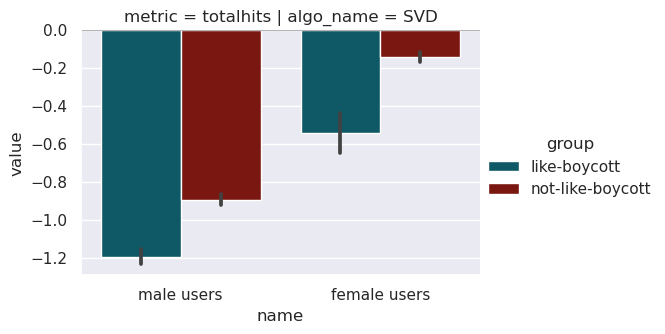

In [56]:
df1 = Partial_users(gender_boycotts)
#df2 = Partial_users(genre_boycotts)
#df3 = Partial_users(power_boycotts)

grid, (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot2(
    pd.concat([df1[
        #(df1.name.str.contains('female')) & 
        (df1.algo_name == 'SVD')],
        #df2[(df2.name.str.contains('documentary')) & (df2.algo_name == 'SVD')],
        #df3[(df3.name.str.contains('power')) & (df3.algo_name == 'SVD')]
    
    ]),
    metrics=metrics,
    increase=USE_INCREASE, percents=USE_PERCENTS,
    groups=[
        #'non-boycott', 
        'like-boycott', 
        #'expected',
        'not-like-boycott',
    ],
    height=3.5,
    kind='bar',
    flip=True,
    filename='h1.svg', save=False,
    palette=palette,
    aspect=1.5
)

plt.show()

## Male User and Female User Boycotts

len of df (number of experiments included) 20
Num users boycotting: 0.5019867549668875. As a percent: 50.19867549668875
Num users boycotting: 0.19801324503311254. As a percent: 19.801324503311253
{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -1.1925367956524755, 'nb': -1.034039480441805, 'not-like': -0.8913479444205755, 'expec': -0.9840941181605078}
totalhits SVD male users, percent_increase_totalhits_expected, percent_increase_totalhits_non-boycott
Ratio: 1.050752627578606, pval: 0.0017682834389991982
LB to NB ratio: 1.3379026710244888
lb_diff, mean_lb - mean_nl -2.3756339860623195
pos = lb has more hits
{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.540464

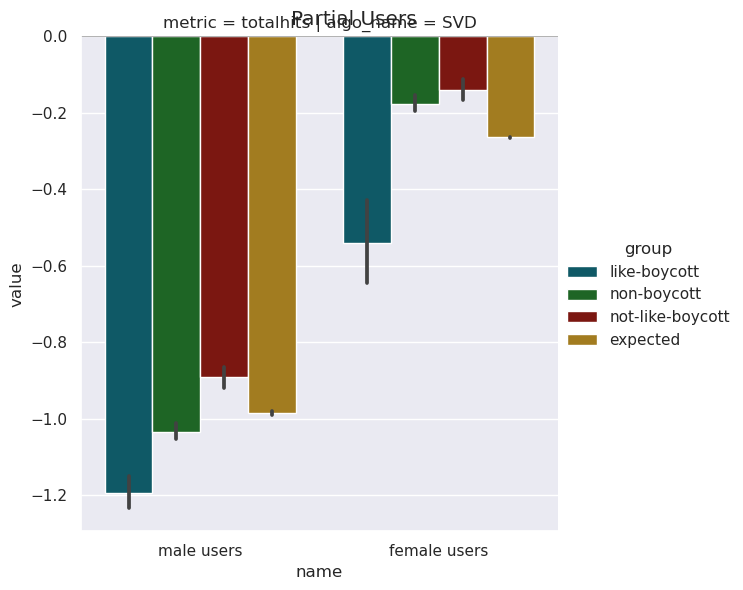

In [57]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(gender_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless
for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
for key in all_vals.keys():
    all_vals[key].update(vals[key])
    
print(all_vals)

plt.show()

# Power Boycotts

Below, the power boycotts show a very weird results. Warrants double checks.

In [58]:
# (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(power_boycotts)
# running_totals['total'] += total
# running_totals['total_sig'] += total_sig
# running_totals['total_less'] += total_less
# running_totals['total_more'] += total_more
# running_totals['total_lbless'] += total_lbless

# for key in all_diffs.keys():
#     all_diffs[key].update(diffs[key])
#     all_ratios[key].update(ratios[key])
# for key in all_vals.keys():
#     all_vals[key].update(vals[key])


# plt.show()

# Age Boycotts

len of df (number of experiments included) 70
Num users boycotting: 0.1382450331125828. As a percent: 13.82450331125828
Num users boycotting: 0.12781456953642384. As a percent: 12.781456953642383
Num users boycotting: 0.05745033112582783. As a percent: 5.7450331125827825
Num users boycotting: 0.06374172185430463. As a percent: 6.374172185430463
Num users boycotting: 0.04403973509933774. As a percent: 4.403973509933774
Num users boycotting: 0.02566225165562914. As a percent: 2.566225165562914
Num users boycotting: 0.24288079470198679. As a percent: 24.288079470198678
{'lb': 'percent_increase_totalhits_like-boycott', 'nb': 'percent_increase_totalhits_non-boycott', 'not-like': 'percent_increase_totalhits_not-like-boycott', 'expec': 'percent_increase_totalhits_expected'}
{'lb': -0.34209179571834897, 'nb': -0.2096820872423822, 'not-like': -0.19960372375656382, 'expec': -0.1975754490607598}
totalhits SVD 35-44, percent_increase_totalhits_expected, percent_increase_totalhits_non-boycott
Ratio

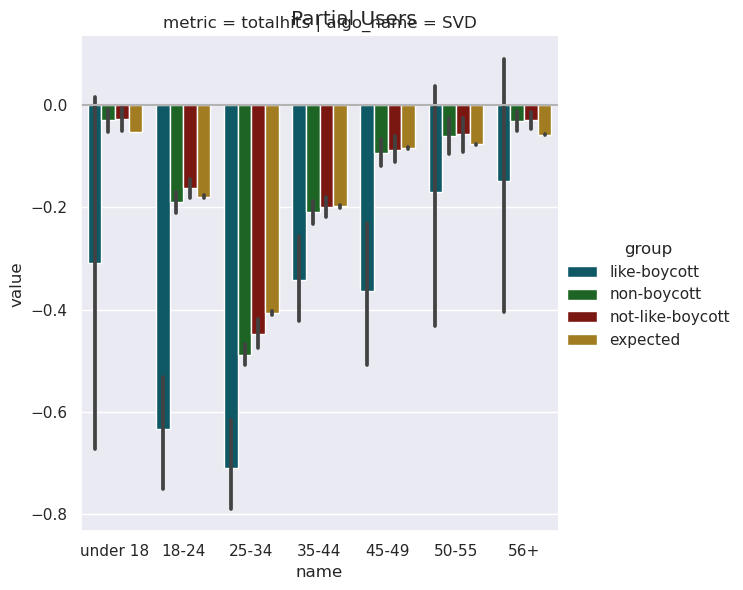

In [59]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(age_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
for key in all_vals.keys():
    all_vals[key].update(vals[key])

plt.show()


# Occupation Boycotts

In [60]:
# (total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(occupation_boycotts)
# running_totals['total'] += total
# running_totals['total_sig'] += total_sig
# running_totals['total_less'] += total_less
# running_totals['total_more'] += total_more
# running_totals['total_lbless'] += total_lbless

# for key in all_diffs.keys():
#     all_diffs[key].update(diffs[key])
#     all_ratios[key].update(ratios[key])
# for key in all_vals.keys():
#     all_vals[key].update(vals[key])
# plt.show()

# State Boycotts

States seemed interesting and slowed the page down a bit, so I commented out for now.
Main conclusion was that state-based boycotts seem to be pretty ineffective for basically every state.
One funny result was that it seems California users have especially low-value ratings - the performance degradation was quite off from the expected degradation (b/c CA has a lot of users).

In [61]:
plot_all_three_scenarios(state_boycotts)

len of df (number of experiments included) 520
Num users boycotting: 0.001655629139072848. As a percent: 0.16556291390728478
Num users boycotting: 0.0009933774834437086. As a percent: 0.09933774834437085
Num users boycotting: 0.0004966887417218543. As a percent: 0.04966887417218543
Num users boycotting: 0.034602649006622514. As a percent: 3.4602649006622515
Num users boycotting: 0.02549668874172185. As a percent: 2.549668874172185
Num users boycotting: 0.004966887417218542. As a percent: 0.49668874172185423
Num users boycotting: 0.003311258278145696. As a percent: 0.33112582781456956
Num users boycotting: 0.002483443708609271. As a percent: 0.24834437086092712
Num users boycotting: 0.010596026490066223. As a percent: 1.0596026490066224
Num users boycotting: 0.0097682119205298. As a percent: 0.97682119205298
Num users boycotting: 0.004470198675496689. As a percent: 0.4470198675496689
Num users boycotting: 0.0009933774834437086. As a percent: 0.09933774834437085
Num users boycotting: 0.0

((52, 40, 13, 39, 31),
 (defaultdict(dict,
              {'nb': {'state us_vt': 0.01337361893434703,
                'state us_ms': 0.018426459300248287,
                'state us_nan': 0.029183724457765164,
                'state us_ma': -0.0042684327633864885,
                'state us_oh': -0.005165318178352599,
                'state us_nh': 0.026128919903909534,
                'state us_ar': 0.014197983969621731,
                'state us_ne': 0.03723513909876343,
                'state us_ga': -0.0014363756691112145,
                'state us_az': 0.033672619895426255,
                'state us_nv': 0.011082198327537207,
                'state us_nd': 0.01861711321728534,
                'state us_nc': 0.009725486169902035,
                'state us_sc': 0.032386809595887085,
                'state us_ky': 0.02518301132330051,
                'state us_pa': 0.016883265660528973,
                'state us_mo': 0.031996697311807806,
                'state us_tx': 0.005178843593055

len of df (number of experiments included) 520
Num users boycotting: 0.001655629139072848. As a percent: 0.16556291390728478
Num users boycotting: 0.0009933774834437086. As a percent: 0.09933774834437085
Num users boycotting: 0.0004966887417218543. As a percent: 0.04966887417218543
Num users boycotting: 0.034602649006622514. As a percent: 3.4602649006622515
Num users boycotting: 0.02549668874172185. As a percent: 2.549668874172185
Num users boycotting: 0.004966887417218542. As a percent: 0.49668874172185423
Num users boycotting: 0.003311258278145696. As a percent: 0.33112582781456956
Num users boycotting: 0.002483443708609271. As a percent: 0.24834437086092712
Num users boycotting: 0.010596026490066223. As a percent: 1.0596026490066224
Num users boycotting: 0.0097682119205298. As a percent: 0.97682119205298
Num users boycotting: 0.004470198675496689. As a percent: 0.4470198675496689
Num users boycotting: 0.0009933774834437086. As a percent: 0.09933774834437085
Num users boycotting: 0.0

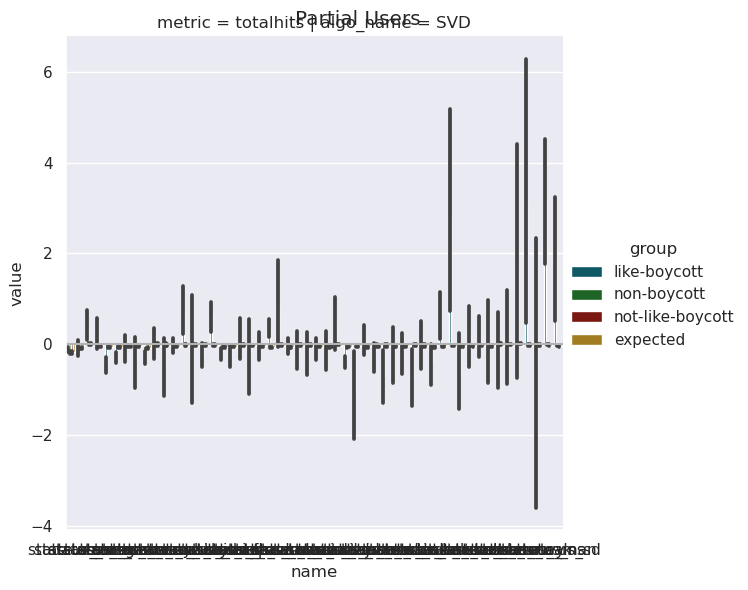

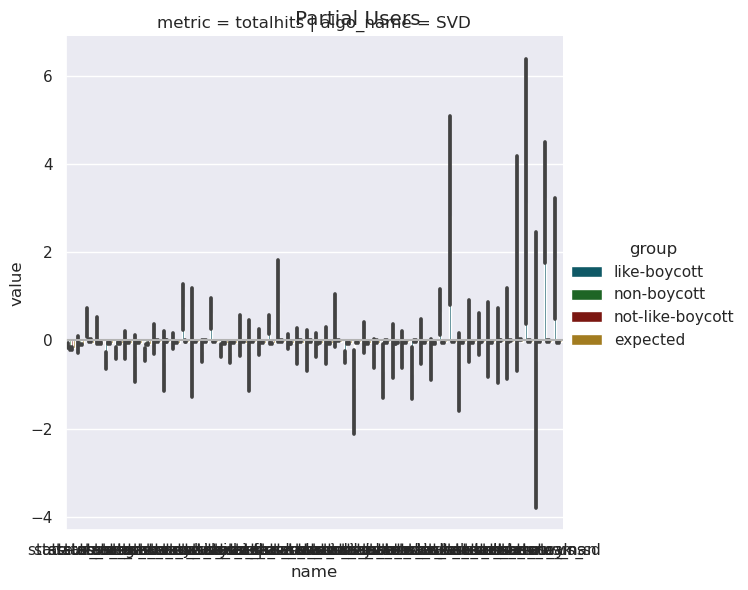

In [62]:
(total, total_sig, total_less, total_more, total_lbless), (diffs, ratios, vals) = plot_all_three_scenarios(state_boycotts)
running_totals['total'] += total
running_totals['total_sig'] += total_sig
running_totals['total_less'] += total_less
running_totals['total_more'] += total_more
running_totals['total_lbless'] += total_lbless

for key in all_diffs.keys():
    all_diffs[key].update(diffs[key])
    all_ratios[key].update(ratios[key])
for key in all_vals.keys():
    all_vals[key].update(vals[key])
plt.show()

# Reported Results: Total # of groups with overall effect less than expected

In [63]:
running_totals

{'total': 61,
 'total_sig': 49,
 'total_less': 18,
 'total_more': 43,
 'total_lbless': 40}

In [64]:
k_max = max(all_ratios['nb'], key=all_ratios['nb'].get)
print(k_max, all_ratios['nb'][k_max])

k_min = min(all_ratios['nb'], key=all_ratios['nb'].get)
print(k_min, all_ratios['nb'][k_min])

state us_ks 1.2610571808969013
state us_wy -0.3353377988506628


In [65]:
count = 0
for k, v in all_ratios['nb'].items():
    if v > 1:
        count += 1
count

18

In [66]:
from pprint import pprint
# pprint(all_diffs)
pprint(all_ratios)
# pprint(all_vals)

{'lb': {'18-24': 3.920402689751582,
        '25-34': 1.5857879568902886,
        '35-44': 1.7138547782583617,
        '45-49': 4.159451908347317,
        '50-55': 2.972970483021624,
        '56+': 4.896003993723379,
        'female users': 3.8816170858889962,
        'male users': 1.3379026710244888,
        'state us_ak': -142.93917874143392,
        'state us_al': -83.47163958102209,
        'state us_ar': -4.705741455782878,
        'state us_az': 18.272967361959154,
        'state us_ca': 0.6681905543770901,
        'state us_co': -2.083234670735756,
        'state us_ct': 0.2885168471266235,
        'state us_dc': -15.573943756500592,
        'state us_de': 26.717547571390273,
        'state us_fl': 3.3435948795581965,
        'state us_ga': -4.728329602028515,
        'state us_hi': 37.571682203848766,
        'state us_ia': -33.05437013204385,
        'state us_id': 4.371405189693671,
        'state us_il': 2.260857252829691,
        'state us_in': 3.9158163377022106,
        's

In [67]:
with open('all_ratios.json', 'w') as f:
    json.dump(all_ratios, f)
with open('all_diffs.json', 'w') as f:
    json.dump(all_diffs, f)
with open('all_vals.json', 'w') as f:
    json.dump(all_vals, f)

In [68]:
with open('some_distances.json', 'r') as f:
    group_to_group_to_vectype_to_distancetype_to_ = json.load(f)
    
row_dicts = []
for group, group_to_vectype_to_distancetype_to_ in group_to_group_to_vectype_to_distancetype_to_.items():
    if group == 'all':
        continue
    row_dict = {}
    row_dict['name'] = group
    for group2, vectype_to_distancetype_to_ in group_to_vectype_to_distancetype_to_.items():
        if group2 != 'all':
            continue
        for vectype, distancetype_to_ in vectype_to_distancetype_to_.items():
            for distancetype, val in distancetype_to_.items():
                row_dict['{}_{}'.format(vectype, distancetype)] = val
    row_dicts.append(row_dict)

df = pd.DataFrame(row_dicts)
df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('using threshold 4', '')
    .strip()
    .lower()
    for x in list(df.name)
]

In [69]:
with open('all_ratios.json', 'r') as f:
    all_ratios = json.load(f)
    
with open('all_diffs.json', 'r') as f:
    all_diffs = json.load(f)
    
with open('all_vals.json', 'r') as f:
    all_vals = json.load(f)
    
with open('group_to_num_ratings.json', 'r') as f:
    group_to_num_ratings = json.load(f)
temp_df = pd.DataFrame.from_dict(group_to_num_ratings, orient='index')
temp_df.index = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('using threshold 4', '')
    .strip()
    .lower()
    for x in list(temp_df.index)
]
print(temp_df)
group_to_num_ratings = temp_df.to_dict()[0]


#print(group_to_num_ratings)    
lb_ratios = all_ratios['lb']
nb_ratios = all_ratios['nb']



row_dicts = []
for key, val in lb_ratios.items():
    row_dict = {
        'name': key,
        'like-boycott-ratio': val,
        'non-boycott-ratio': nb_ratios[key],
        'like-boycott-diff': all_diffs['lb'][key],
        'non-boycott-diff': all_diffs['lb'][key],
        'num_ratings': group_to_num_ratings[key],
        'like-boycott-val': all_vals['lb'][key],
        'not-like-val': all_vals['not-like'][key],
    }
    row_dicts.append(row_dict)
ratios_df = pd.DataFrame(row_dicts)

df = df.merge(right=ratios_df, on='name', how='inner')
print(df.head())

                    0
male users     753769
female users   246440
under 18        27211
18-24          183536
25-34          395556
...               ...
state us_ak       911
state us_ms       557
state us_nan      607
state us_sd      1935
all           1000209

[83 rows x 1 columns]
           name  implicit_euclidean  implicit_cosine  explicit_euclidean  \
0    male users            0.526198         0.003839            0.595161   
1  female users            1.333507         0.036824            1.508274   
2      under 18            2.153858         0.107794            2.052510   
3         18-24            1.455582         0.040974            1.575967   
4         25-34            0.963761         0.007190            0.975738   

   explicit_cosine  like-boycott-ratio  non-boycott-ratio  like-boycott-diff  \
0         0.000005            1.337903           1.050753          -2.375634   
1         0.000033            3.881617           0.665833          -2.729437   
2         0.0000

In [70]:
names = {
    'name': 'Name', 'num_ratings': '# Ratings', 
    'like-boycott-ratio': 'Similar User Effect Ratio',
    'like-boycott-val':  '% change surfaced hits, similar users',
    'not-like-val':  '% change surfaced hits, other users',
}

table_df = df[['name', 'num_ratings', 'like-boycott-val', 'not-like-val', 'like-boycott-ratio']][
        df.name.isin([
        'male users', 'female users', 'power users', 
        '25-34', '56+', 'under 18', 'state us_ak','state us_ny'
        'scientist', 
        'artist',
    ])
    #df.num_ratings > 150000
].rename(index=str, columns=names)

print(table_df)

            Name  # Ratings  % change surfaced hits, similar users  \
0     male users     753769                              -1.192537   
1   female users     246440                              -0.540465   
2       under 18      27211                              -0.309644   
4          25-34     395556                              -0.708791   
8            56+      38780                              -0.148620   
57   state us_ak        911                               3.118072   

    % change surfaced hits, other users  Similar User Effect Ratio  
0                             -0.891348                   1.337903  
1                             -0.139237                   3.881617  
2                             -0.027977                  11.067913  
4                             -0.446965                   1.585788  
8                             -0.030355                   4.896004  
57                            -0.021814                -142.939179  


# Reported Results: Table 1

In [71]:
html = table_df.to_html(
    index=False,
    float_format='%.2f',
    columns=[
        'Name', '# Ratings', 
        names['like-boycott-val'],
        names['not-like-val'],
        'Similar User Effect Ratio'
]
)
css = """
<style>
body {column-count: 1 !important;}
table {
    width: 4.5in; height:3in;
        font-size: 9pt;
}
td {
    border: 1px solid;
}
th, td, table {
    border-left: none;
    border-right: none;
    padding-left: 10px;
}

</style>
"""
table_df.to_csv('table1.csv', index=False, float_format='%.2f', columns=[
        'Name', '# Ratings', 
        names['like-boycott-val'],
        names['not-like-val'],
        'Similar User Effect Ratio'
])

with open('table.html', 'w') as f:
    f.write('<link rel="stylesheet" href="pubcss-acm-sigchi.css">' + css + html)

# Reported Results: Figure 4 and Correlation


len, std, mean 17 178628.71597730982 150304.0588235294


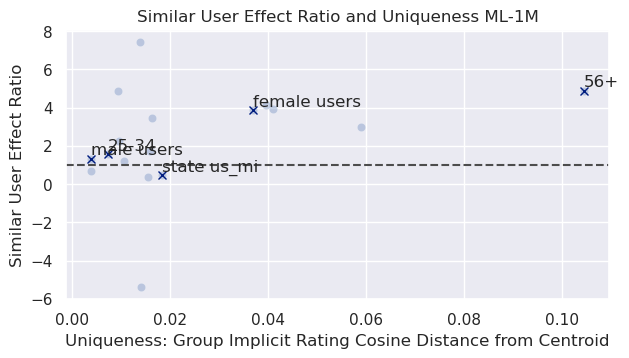

0.3503024120290753 0.16805890415495894
0.35
0.38 0.1298634258225738
    implicit_cosine  num_ratings  like-boycott-ratio          name
9          0.003791       181526            0.668191   state us_ca
0          0.003839       753769            1.337903    male users
4          0.007190       395556            1.585788         25-34
14         0.009320        52101            4.885723   state us_tx
35         0.009481        53000            2.260857   state us_il
10         0.010452        63619            1.207723   state us_mn
13         0.013768        45112            7.433917   state us_ma
30         0.014082        39837           -5.381371   state us_oh
20         0.015528        37603            0.347870   state us_wa
5          0.015831       199003            1.713855         35-44
17         0.016193        71452            3.464910   state us_ny
32         0.018195        37712            0.458173   state us_mi
1          0.036824       246440            3.881617  female 

In [72]:
# Implicit Cosine vs. LB Ratio
sns.set(style="darkgrid")
sns.set_color_codes("dark")

fig, ax = plt.subplots(1,1, figsize=(7, 3.5))
filtered = df[df.num_ratings >= 30000]
print('len, std, mean', len(filtered.num_ratings), np.std(filtered.num_ratings), np.mean(filtered.num_ratings))
#filtered = df

y = 'like-boycott-ratio'

sns.scatterplot(
    x='implicit_cosine', y=y, data=filtered,
    ax=ax, 
    #marker=".", 
    #line_kws={'alpha':.3},
    alpha=0.3
)

def label_point(x, y, val, ax, names):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if str(point['val']) in names:
            ax.text(
                point['x'], point['y']+0.2, str(point['val']), 
            )
            ax.plot(point['x'], point['y'], 'bx')

label_point(
    filtered.implicit_cosine, filtered[y], filtered.name, plt.gca(),
    names=[
        'male users', 'female users', 'power users', 
        '25-34', '56+', 'under 18', 'state us_mi',' state us_oh'
        'scientist', 
        'artist',]
)  

plt.xlabel('Uniqueness: Group Implicit Rating Cosine Distance from Centroid')
plt.title('Similar User Effect Ratio and Uniqueness ML-1M')
plt.ylabel('Similar User Effect Ratio')

ax.axhline(1, color='0.3', linestyle='--')
plt.savefig('implicitcosine_vs_lbratio.png', bbox_inches='tight', dpi=300)
plt.show()
pearson_val, pearson_p = pearsonr(filtered['implicit_cosine'], filtered[y])
print(pearson_val, pearson_p)
print(round(pearson_val, 2))
spearman_val, spearman_p = spearmanr(filtered['implicit_cosine'], filtered[y])
print(round(spearman_val, 2), spearman_p)

print(filtered[['implicit_cosine', 'num_ratings', y, 'name']].sort_values('implicit_cosine'))

In [74]:
print(pearsonr(df['implicit_cosine'], df['like-boycott-ratio']))
print(pearsonr(df['implicit_cosine'], df['like-boycott-val']))
print(pearsonr(df['implicit_cosine'], df['not-like-val']))

(-0.012531065148210091, 0.9236399147941551)
(0.668593830258992, 3.900132332409999e-09)
(0.2683053746276015, 0.036556630113532766)


In [73]:
names = {
    'name': 'Name', 'num_ratings': '# Ratings', 
    'like-boycott-ratio': 'Similar User Effect Ratio',
    'like-boycott-val':  '% change surfaced hits, similar users',
    'not-like-val':  '% change surfaced hits, other users',
}

table2_df = df[['name', 'num_ratings', 'like-boycott-val', 'not-like-val', 'like-boycott-ratio']].rename(index=str, columns=names)

table2_df.to_csv('table2.csv', index=False, float_format='%.2f', columns=[
        'Name', '# Ratings', 
        names['like-boycott-val'],
        names['not-like-val'],
        'Similar User Effect Ratio'
])

print(table2_df)

            Name  # Ratings  % change surfaced hits, similar users  \
0     male users     753769                              -1.192537   
1   female users     246440                              -0.540465   
2       under 18      27211                              -0.309644   
3          18-24     183536                              -0.634228   
4          25-34     395556                              -0.708791   
..           ...        ...                                    ...   
56   state us_wy       1151                               1.608700   
57   state us_ak        911                               3.118072   
58   state us_ms        557                              -0.459121   
59  state us_nan        607                               3.231240   
60   state us_sd       1935                               1.864669   

    % change surfaced hits, other users  Similar User Effect Ratio  
0                             -0.891348                   1.337903  
1                    